In [ ]:
# Instead of original training dataframe, we need to make a table of
# with climate data as columns and individual months for individual glaciers
# as rows. In training we need to batch the months to match summer, winter and
# annual mass balance, aggregate the results for each month and evaluate it against
# the summer, winter and annual mass balance using a custom loss function. We can shuffle the batches, 
# but we need to keep the respective batches themselves in the correct order. 

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results
from sklearn.model_selection import KFold
from itertools import product
from sklearn.model_selection import GroupKFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from plotting_functions import plot_prediction_per_fold



## Monthly predictions using dummy dataset

In [2]:
# Create dummy feature dataset
def create_feature_dataset(n_rows):

    np.random.seed(0)

    data = {
        "t2m": np.random.uniform(-5, 5, n_rows), 
        "tp": np.random.uniform(0, 100, n_rows),  
        "fal": np.random.uniform(0, 1, n_rows),   
        "ssr": np.random.uniform(0, 100, n_rows) 
    }

    df = pd.DataFrame(data)

    return df

num_rows = 600
    
# Create dataset
df_features = create_feature_dataset(num_rows)

# Features
X_values = df_features.values

# Number of months to aggregate
months = 6
num_rows_y = int(num_rows/months)

# Target
y_values = np.random.uniform(-5, 5, num_rows_y)

# Target repeated months times
y_values_rep = np.repeat(y_values, months)

### Training using low-level Booster interface

In [10]:
# When defining a custom loss function with the native XGBoost api, input arguments
# are (predictions, Dmatrix). Dmatrix contains targets. 
def custom_mse_native(y_pred, dtrain):
    """
    Custom Mean Squared Error loss for seasonal data.
    """
    # Get the true values
    y_true = dtrain.get_label()

    # Assuming 6-month seasons, reshape predictions and true values
    y_pred_seasonal = y_pred.reshape(-1, 6)
    y_true_seasonal = y_true.reshape(-1, 6)

    # Aggregate predictions and true values over the season
    # Predictions are summed over months, true values are repeated so mean is taken
    y_pred_agg = np.sum(y_pred_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    gradient = y_pred_agg - y_true_agg
    hessian = np.ones_like(gradient)

    # Reshape gradient and hessian to match the original shape
    gradient = np.repeat(gradient, 6)
    hessian = np.repeat(hessian, 6)

    return gradient, hessian

# Convert data to DMatrix, data format used in native XGBoost
dtrain = xgb.DMatrix(X_values, label=y_values_rep)

# Parameters
params = {'max_depth': 6, 'eta': 0.3}

# Train model
# num_boost_round is in the case of the Booster interface the same as n_estimators in XGBregressor
model = xgb.train(params, dtrain, obj=custom_mse_native, num_boost_round=100)


In [11]:
preds = model.predict(dtrain)
print(preds[:6].sum())
print(y_values[0])

3.8658118
3.8668322084745235


### Using Scikit-learn XGBRegressor interface

In [14]:
# When defining a custom loss function with the scikit-learn XGBoost api, 
# input arguments are (target, predictions)
def custom_mse_sklearn(y_true, y_pred):
    
    # Reshape the predictions and true values to represent seasons (6 months in this case)
    y_pred_seasonal = y_pred.reshape(-1, 6)
    y_true_seasonal = y_true.reshape(-1, 6)

    # Aggregate predictions and true values over the season
    y_pred_agg = np.sum(y_pred_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    gradient = y_pred_agg - y_true_agg
    hessian = np.ones_like(gradient)

    # Reshape gradient and hessian to match the original shape
    gradient = np.repeat(gradient, 6)
    hessian = np.repeat(hessian, 6)

    return gradient, hessian

# Initialize XGBRegressor with the custom objective
model_reg = xgb.XGBRegressor(objective=custom_mse_sklearn)

# Train the model
model = model_reg.fit(X_values, y_values_rep)


In [15]:
preds = model.predict(X_values)

In [16]:
preds[:10]

array([0.6568314 , 0.7752539 , 0.8081221 , 1.2794617 , 0.17567207,
       0.17047073, 0.8575948 , 0.430232  , 0.12330425, 0.95460874],
      dtype=float32)

In [17]:
print(preds[:6].sum())
print(y_values[0])


3.8658118
3.8668322084745235


## Test monthly predictions using summer mass balance

### Import and process data

In [2]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_20512\398696404.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [3]:
# Manually select test glaciers (14 glaciers)
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

# Get test dataset for each of annual, winter and summer mass balance
df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3133 has 38 points
# 3137 has 65 points
# 3138 has 6 points
# 3141 has 72 points

# Get training dataset for each of annual, winter and summer mass balance
df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=8
df_train_summer['n_months']=6
df_test_annual['n_months']=12
df_test_winter['n_months']=8
df_test_summer['n_months']=6

print(f'Train/test annual: {len(df_train_annual)}/{len(df_test_annual)}')
print(f'Train/test winter: {len(df_train_winter)}/{len(df_test_winter)}')
print(f'Train/test summer: {len(df_train_summer)}/{len(df_test_summer)}')
print(f'All train/test: {len(df_train_annual)+len(df_train_winter)+len(df_train_summer)} / {len(df_test_annual)+len(df_test_winter)+len(df_test_summer)}')
print(f'Fraction train/test: {(len(df_train_annual)+len(df_train_winter)+len(df_train_summer)) / (len(df_test_annual)+len(df_test_winter)+len(df_test_summer)+len(df_train_annual)+len(df_train_winter)+len(df_train_summer))} / {(len(df_test_annual)+len(df_test_winter)+len(df_test_summer)) /(len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer))}')
print(f'Total entries: {len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer)}')


Train/test annual: 2845/1065
Train/test winter: 2752/1000
Train/test summer: 2901/1028
All train/test: 8498 / 3093
Fraction train/test: 0.7331550340781641 / 0.26684496592183593
Total entries: 11591


C:\Users\kasj\AppData\Local\Temp\ipykernel_20512\1108104880.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_20512\1108104880.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_20512\1108104880.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [4]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
#sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
#f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])

In [5]:
df_train_summer_clean

,BREID,altitude,balance,aspect,slope,t2m_oct,t2m_nov,t2m_dec,t2m_jan,t2m_feb,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,n_months
172,596,990.0,-3.41,2.509464,0.238202,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001702,0.001953,0.004025,0.002591,0.006047,1001.181943,6
173,596,996.0,-2.16,2.474161,0.117946,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002906,0.003402,0.003066,0.004062,0.004951,1001.181943,6
174,596,988.0,-2.90,2.509464,0.238202,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003094,0.001567,0.003896,0.004033,0.004845,1001.181943,6
175,596,990.0,-3.16,2.478294,0.146882,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000861,0.004021,0.006549,0.003302,0.003687,1001.181943,6
176,596,990.0,-1.90,2.478294,0.146882,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001514,0.004824,0.003683,0.004470,0.001097,1001.181943,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,3129,1551.0,-2.35,2.115165,0.111223,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003067,0.004948,0.001373,0.001677,0.008620,994.833212,6
3729,3129,1571.0,-1.29,2.312361,0.097301,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.005468,0.009837,0.010945,0.007251,0.008933,994.833212,6
3730,3129,1587.0,-1.80,2.482095,0.070551,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001531,0.006192,0.002394,0.006272,0.007284,994.833212,6
3731,3129,1590.0,-2.81,2.339748,0.073072,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.004337,0.003802,0.004859,0.004397,0.011932,994.833212,6


In [6]:
df_train_summer_clean = df_train_summer_clean.dropna(axis=1, how='all')
df_train_summer_clean.insert(0, 'id', list(range(len(df_train_summer_clean))))


In [7]:
#df_train_summer_clean.columns.to_list()

In [8]:
# Columns that are not monthly climate variables (identifiers and static variables)
id_vars = ['id','BREID', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
months_order = ['may', 'jun', 'jul', 'aug', 'sep']

# Prepare a list to hold the reshaped DataFrames for each variable
df_list = []

for var in variables:
    # Filter columns for the current variable and the ID columns
    cols = [col for col in df_train_summer_clean.columns if col.startswith(var) or col in id_vars]
    df_var = df_train_summer_clean[cols]

    # Rename the columns to have just the month
    df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

    # Melt the DataFrame to long format and add month order
    df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
    df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

    # Append the reshaped DataFrame to the list
    df_list.append(df_melted)

# Combine all reshaped DataFrames
df_final = df_list[0]
for df_temp in df_list[1:]:
    df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='left')

# Sort the DataFrame based on ID variables and month
df_final = df_final.sort_values(by=id_vars + ['month'])


In [9]:
df_final

,id,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
2901,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
5802,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
8703,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
11604,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2900,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
5801,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
8702,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
11603,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [10]:
df_final.reset_index(drop=True, inplace=True)
df_final

,id,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
1,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
2,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
3,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
4,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
14501,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
14502,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
14503,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [11]:
# Prepare test

# Select features for training
df_test_annual_clean = df_test_annual.drop(drop_cols, axis=1)
df_test_winter_clean = df_test_winter.drop(drop_cols, axis=1)
df_test_summer_clean = df_test_summer.drop(drop_cols, axis=1)
df_test_annual_clean = df_test_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_test_winter_clean = df_test_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_test_summer_clean = df_test_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_test_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_test_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_test_all = pd.concat([df_test_annual_clean, df_test_summer_clean, df_test_winter_clean])
df_test_all.reset_index(drop=True, inplace=True)


In [12]:
df_test_summer_clean = df_test_summer_clean.dropna(axis=1, how='all')
df_test_summer_clean.insert(0, 'id', list(range(len(df_test_summer_clean))))


In [13]:
df_test_summer_clean

,id,BREID,altitude,balance,aspect,slope,t2m_may,t2m_jun,t2m_jul,t2m_aug,...,ssrd_jul,ssrd_aug,ssrd_sep,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,n_months
0,0,54,471.0,-6.24,0.629597,0.278773,277.677979,283.339630,283.829285,283.778412,...,15538729.0,10510849.0,6908671.0,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,6
1,1,54,439.0,-4.35,0.585924,0.296590,273.853424,278.533508,286.991089,283.409485,...,18042530.0,11039758.0,5959149.5,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,6
2,2,54,444.0,-4.17,0.663261,0.302508,275.326904,277.934570,282.700439,284.425964,...,16689025.0,10871432.0,5295579.5,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,6
3,3,54,444.0,-4.37,0.663261,0.302508,277.405426,279.781555,284.442657,282.017212,...,12798462.0,10218002.0,5514606.5,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,6
4,4,54,468.0,-4.05,0.836757,0.309196,272.579590,278.621582,283.518036,282.460541,...,14254989.0,10143777.0,7109445.5,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,1023,3141,1078.0,-3.57,2.906044,0.131717,276.051880,279.342010,282.147797,282.897827,...,13498130.0,12668262.0,6896097.0,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,6
3925,1024,3141,1078.0,-4.29,2.906044,0.131717,277.164032,280.542206,284.284760,282.710297,...,16972544.0,13084008.0,7385662.5,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,6
3926,1025,3141,1079.0,-3.80,2.906044,0.131717,274.069031,278.133453,281.378021,283.121002,...,14995219.0,13300601.0,8539609.0,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,6
3927,1026,3141,1078.0,-4.38,2.906044,0.131717,278.187347,283.209045,282.545563,282.466614,...,12746544.0,10608194.0,8065051.0,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,6


In [14]:
# Columns that are not monthly climate variables (identifiers and static variables)
id_vars = ['id','BREID', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
months_order = ['may', 'jun', 'jul', 'aug', 'sep']

# Prepare a list to hold the reshaped DataFrames for each variable
df_list = []

for var in variables:
    # Filter columns for the current variable and the ID columns
    cols = [col for col in df_test_summer_clean.columns if col.startswith(var) or col in id_vars]
    df_var = df_test_summer_clean[cols]

    # Rename the columns to have just the month
    df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

    # Melt the DataFrame to long format and add month order
    df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
    df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

    # Append the reshaped DataFrame to the list
    df_list.append(df_melted)

# Combine all reshaped DataFrames
df_test_final = df_list[0]
for df_temp in df_list[1:]:
    df_test_final = pd.merge(df_test_final, df_temp, on=id_vars + ['month'], how='left')

# Sort the DataFrame based on ID variables and month
df_test_final = df_test_final.sort_values(by=id_vars + ['month'])

In [15]:
df_test_final

,id,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,54,471.0,-6.24,0.629597,0.278773,341.227919,6,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1028,0,54,471.0,-6.24,0.629597,0.278773,341.227919,6,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2056,0,54,471.0,-6.24,0.629597,0.278773,341.227919,6,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3084,0,54,471.0,-6.24,0.629597,0.278773,341.227919,6,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4112,0,54,471.0,-6.24,0.629597,0.278773,341.227919,6,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,1027,3141,1078.0,-4.44,2.906044,0.131717,917.419759,6,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
2055,1027,3141,1078.0,-4.44,2.906044,0.131717,917.419759,6,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
3083,1027,3141,1078.0,-4.44,2.906044,0.131717,917.419759,6,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
4111,1027,3141,1078.0,-4.44,2.906044,0.131717,917.419759,6,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


In [16]:
# Select features for training
df_test_X = df_test_final.drop(['balance','BREID','n_months','month'], axis=1)

# Select labels for training
df_test_y = df_test_final[['balance']]

# Get arrays of features and targets
X_test, y_test = df_test_X.values, df_test_y.values

In [17]:
df_test_X

,id,altitude,aspect,slope,altitude_climate,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,471.0,0.629597,0.278773,341.227919,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1028,0,471.0,0.629597,0.278773,341.227919,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2056,0,471.0,0.629597,0.278773,341.227919,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3084,0,471.0,0.629597,0.278773,341.227919,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4112,0,471.0,0.629597,0.278773,341.227919,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,1027,1078.0,2.906044,0.131717,917.419759,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
2055,1027,1078.0,2.906044,0.131717,917.419759,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
3083,1027,1078.0,2.906044,0.131717,917.419759,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
4111,1027,1078.0,2.906044,0.131717,917.419759,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


In [18]:
# Add identifier in df_final to indicate which instances belong together
df_final

,id,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
1,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
2,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
3,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
4,0,596,990.0,-3.41,2.509464,0.238202,1001.181943,6,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
14501,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
14502,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
14503,2900,3129,1587.0,-1.19,2.526225,0.068208,994.833212,6,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [19]:
# # Calculate the number of unique integers needed
# length = len(df_final)
# num_months = 5

# num_integers = length // num_months

# # Create the array with integers repeated 5 times
# repeated_integers = np.repeat(np.arange(1, num_integers + 1), num_months)

# # Truncate the array if it exceeds the desired length
# #if len(repeated_integers) > length:
# #    repeated_integers = repeated_integers[:length]

# # Add the new array as the first column in the DataFrame
# df_final.insert(0, 'id', repeated_integers)

# df_final

### Set up folds

In [20]:
# Select features for training
df_train_X = df_final.drop(['balance','BREID','n_months','month','id'], axis=1)

# Select labels for training
df_train_y = df_final[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values


In [21]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_final['id'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train, y_train, gp_s))

#print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
#print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
#print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
#print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
#print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
#print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
#print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
#print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
#print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
#print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))
print(len(gp_s))
print(y_train.shape)
print(X_train.shape)

14505
(14505, 1)
(14505, 11)


In [22]:
# Check folds
fold_indices = []

for train_index, test_index in group_kf.split(X_train, y_train, gp_s):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("shape(train):", train_index.shape, "test:", test_index.shape)
    fold_indices.append((train_index, test_index))


TRAIN: [    5     6     7 ... 14497 14498 14499] TEST: [    0     1     2 ... 14502 14503 14504]
shape(train): (11600,) test: (2905,)
TRAIN: [    0     1     2 ... 14502 14503 14504] TEST: [   20    21    22 ... 14497 14498 14499]
shape(train): (11605,) test: (2900,)
TRAIN: [    0     1     2 ... 14502 14503 14504] TEST: [   15    16    17 ... 14482 14483 14484]
shape(train): (11605,) test: (2900,)
TRAIN: [    0     1     2 ... 14502 14503 14504] TEST: [   10    11    12 ... 14477 14478 14479]
shape(train): (11605,) test: (2900,)
TRAIN: [    0     1     2 ... 14502 14503 14504] TEST: [    5     6     7 ... 14472 14473 14474]
shape(train): (11605,) test: (2900,)


### Define custom objective and custom evaluation functions

In [23]:
# Define custom objective function (used in model training) for native XGBoost

# When defining a custom loss function with the native XGBoost api, input arguments
# are (predictions, Dmatrix). Dmatrix contains targets. 
def seasonal_mse(y_pred, dtrain):
    """
    Custom Mean Squared Error objective function for seasonal data.
    XGBoost native api.

    """
    # Get the true values
    y_true = dtrain.get_label()

    # Assuming 5-month seasons, reshape predictions and true values
    y_pred_seasonal = y_pred.reshape(-1, 5)
    y_true_seasonal = y_true.reshape(-1, 5)

    # Aggregate predictions and true values over the season
    # Predictions are summed over months, true values are repeated so mean is taken
    y_pred_agg = np.sum(y_pred_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    gradient = y_pred_agg - y_true_agg
    hessian = np.ones_like(gradient)

    # Reshape gradient and hessian to match the original shape
    gradient = np.repeat(gradient, 5)
    hessian = np.repeat(hessian, 5)

    return gradient, hessian

# Define custom evaluation function for native XGBoost api (used in cross-validation) 
# This function is not used in training, but is used in evaluating the predictions
# from the trained model. 
def custom_mse_eval(y_pred, dval):
    """
    Custom Mean Squared Error evaluation function for seasonal data.
    XGBoost native api.
    """
    # Get true seasonal mass balance
    y_val = dval.get_label()
    
    # Aggregate predicted and true monthly over the season.
    y_pred_agg = y_pred.reshape(-1, 5).sum(axis=1)
    y_val_mean = y_val.reshape(-1,5).mean(axis=1)

    # Compute mean squared error between predictions and observations
    error = y_pred_agg - y_val_mean
    squared_error = np.square(error)
    mse = np.mean(squared_error)

    return 'custom_mse', mse


In [24]:
# Define custom objective function (used in model training) for XGBoost Scikit learn interface

# When defining a custom loss function with the Scikit learn XGBoost api, input arguments
# are (targets, predictions). 
def seasonal_mse_sklearn(y_true, y_pred):
    """
    Custom Mean Squared Error objective function for seasonal data.
    XGBoost Scikit learn api.

    """

    # Assuming 5-month seasons, reshape predictions and true values
    y_pred_seasonal = y_pred.reshape(-1, 5)
    y_true_seasonal = y_true.reshape(-1, 5)

    # Aggregate predictions and true values over the season
    # Predictions are summed over months, true values are repeated so mean is taken
    y_pred_agg = np.sum(y_pred_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    gradient = y_pred_agg - y_true_agg
    hessian = np.ones_like(gradient)

    # Reshape gradient and hessian to match the original shape
    gradient = np.repeat(gradient, 5)
    hessian = np.repeat(hessian, 5)

    return gradient, hessian

# Define custom evaluation function for XGBoost Scikit learn api (used in cross-validation) 
# This function is not used in training, but is used in evaluating the predictions
# from the trained model. 
def custom_mse_eval_sklearn(y_val, y_pred):
    """
    Custom Mean Squared Error evaluation function for seasonal data.
    XGBoost Scikit learn api.
    """
    
    # Aggregate predicted and true monthly over the season.
    y_pred_agg = y_pred.reshape(-1, 5).sum(axis=1)
    y_val_mean = y_val.reshape(-1,5).mean(axis=1)

    # Compute mean squared error between predictions and observations
    error = y_pred_agg - y_val_mean
    squared_error = np.square(error)
    mse = np.mean(squared_error)

    return mse
    

In [25]:
# Custom objective function scikit learn api with additional arguments
# Example:
# def focal_loss(alpha, gamma):
#     def custom_loss(y_pred, y_true):
#         a,g = alpha, gamma
#         def fl(x,t):
#             p = 1/(1+np.exp(-x))
#             return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
#         partial_fl = lambda x: fl(x, y_true)
#         grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
#         hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
#         return grad, hess
#     return custom_loss

# xgb = xgb.XGBClassifier(objective=focal_loss(alpha=0.25, gamma=1))
def seasonal_loss(months):
    def seasonal_mse_sklearn(y_true, y_pred):
        """
        Custom Mean Squared Error objective function for seasonal data.
        XGBoost Scikit learn api.
    
        """
        n = months
        
        # Assuming 5-month seasons, reshape predictions and true values
        y_pred_seasonal = y_pred.reshape(-1, n)
        y_true_seasonal = y_true.reshape(-1, n)

        # Aggregate predictions and true values over the season
        # Predictions are summed over months, true values are repeated so mean is taken
        y_pred_agg = np.sum(y_pred_seasonal, axis=1)
        y_true_agg = np.mean(y_true_seasonal, axis=1)

        # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
        gradient = y_pred_agg - y_true_agg
        hessian = np.ones_like(gradient)

        # Reshape gradient and hessian to match the original shape
        gradient = np.repeat(gradient, n)
        hessian = np.repeat(hessian, n)

        return gradient, hessian
    return seasonal_mse_sklearn

### Using xgb.train() in manual implementation of grid search with cross-validation

In [26]:
# Function to print results of grid search with cross-validation
def print_cv_scores(cv_results):
    
    # Calculate rankings based on mean_test_score
    mean_val_scores = np.array(cv_results['mean_val_score'])
    order = mean_val_scores.argsort()
    ranks = order.argsort()
    cv_results['rank_val_score'] = ranks + 1 
        
    # Find the index of the best mean test score
    best_index = np.argmin(cv_results['mean_val_score'])

    # Retrieve the best score and corresponding parameters
    best_score = cv_results['mean_val_score'][best_index]
    best_params = cv_results['params'][best_index]
    val_scores = cv_results['val_scores'][best_index]
    #train_best_score = cv_results['mean_train_score'][best_index]
    #best_rounds = cv_results['boosting_rounds'][best_index]

    print("Best Mean Validation Score:", best_score)
    print("Validation scores per fold:", val_scores)
    #print("Training score:", train_best_score)
    print("Best Parameters:", best_params)
    #print("Number of boosting rounds for best mean score:", best_rounds)
    #print("Mean number of boosting rounds for best mean score:", np.mean(best_rounds))

In [71]:
# Using xgb.train() in manual implementation of grid search with cross-validation

# Dictionary to store results of grid search
cv_results = {
    'mean_train_score': [],
    'std_train_score': [],
    'mean_val_score': [],
    'val_scores':[],
    'std_val_score': [],
    'params': [],
    'rank_val_score': [],
    'mean_boosting_rounds': [],
    'median_boosting_rounds': [],
    'boosting_rounds': []
    }

#tot_boost_rounds = []

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1, 0.2, 0.3],
    'gamma':[0, 1, 10],
    }

# Early stopping rounds. If performance does not improve after
# early_stopping_rounds, no more trees are built
early_stopping_rounds = None

total_combinations = len(list(product(*param_grid.values())))

with tqdm(total=total_combinations, desc="Hyperparameter Tuning Progress") as pbar:

    for param_combination in product(*param_grid.values()):

        train_scores, val_scores = [], []
        #boosting_rounds = []

        params = dict(zip(param_grid.keys(), param_combination))
        params['disable_default_eval_metric']=True # Disable automatic evaluation of RMSE

        for train_index, val_index in group_kf.split(X_train, y_train, gp_s):
            X_tr, X_val = X_train[train_index], X_train[val_index]
            y_tr, y_val = y_train[train_index], y_train[val_index]

            dtrain = xgb.DMatrix(X_tr, label=y_tr)
            dval = xgb.DMatrix(X_val, label=y_val)

            model = xgb.train(params, dtrain, num_boost_round=500,
                            evals=[(dval,'eval')],
                            early_stopping_rounds=early_stopping_rounds,
                            obj=seasonal_mse, custom_metric=custom_mse_eval, #feval=custom_mse -> feval is deprecated for custom_metric since 1.6.0
                            verbose_eval=False) # eval_metric=None prevents use of default RMSE metric, if not None both custom_mse and RMSE are used.

            #boosting_rounds.append(model.best_iteration)

            #train_scores.append(model.best_score)
            predictions = model.predict(dval)#, iteration_range=(0,model.best_iteration))
            val_scores.append(custom_mse_eval(predictions, dval)[1])
            #tot_boost_rounds.append(boosting_rounds)

        # Calculate mean and standard deviation for training and validation scores
        #cv_results['mean_train_score'].append(np.mean(train_scores))
        #cv_results['std_train_score'].append(np.std(train_scores))
        cv_results['mean_val_score'].append(np.mean(val_scores))
        cv_results['val_scores'].append(val_scores)
        cv_results['std_val_score'].append(np.std(val_scores))
        cv_results['params'].append(params)
        #cv_results['mean_boosting_rounds'] = sum(boosting_rounds) / len(boosting_rounds)
        #cv_results['median_boosting_rounds'] = np.median(boosting_rounds)
        #cv_results['boosting_rounds']=tot_boost_rounds

        # Update progress bar
        pbar.update(1) 

#print_cv_scores(cv_results)

Hyperparameter Tuning Progress: 100%|██████████████████████████████████████████████████| 36/36 [02:56<00:00,  4.89s/it]


In [68]:
print_cv_scores(cv_results)
#cv_results

Best Mean Validation Score: 0.25346828
Best Parameters: {'max_depth': 5, 'eta': 0.01, 'gamma': 0, 'disable_default_eval_metric': True}


In [69]:
cv_results

{'mean_train_score': [],
 'std_train_score': [],
 'mean_val_score': [0.3448649,
  0.34501356,
  0.4251214,
  0.26077154,
  0.31793994,
  0.42290577,
  0.31587452,
  0.35006073,
  0.44774348,
  0.4056681,
  0.4416674,
  0.53502846,
  0.28812727,
  0.29393667,
  0.40338182,
  0.2632807,
  0.30133364,
  0.40432802,
  0.3325386,
  0.35822278,
  0.45547026,
  0.44419783,
  0.46970195,
  0.5291965,
  0.25346828,
  0.2743739,
  0.38839027,
  0.26646692,
  0.29514298,
  0.4033628,
  0.3448348,
  0.3447631,
  0.4510344,
  0.5159787,
  0.49794745,
  0.55265397],
 'std_val_score': [0.019071955,
  0.01907086,
  0.029056111,
  0.019311728,
  0.021898193,
  0.025627138,
  0.01927844,
  0.022618847,
  0.036616717,
  0.033427037,
  0.021930045,
  0.039018396,
  0.011853785,
  0.011728751,
  0.024186093,
  0.021944659,
  0.011387569,
  0.022491613,
  0.033499748,
  0.034930695,
  0.05025573,
  0.028573897,
  0.038772266,
  0.05435048,
  0.014532047,
  0.015280877,
  0.024939358,
  0.020280825,
  0.0175

### Using xgb.cv() for cross-validation in manual implementation of grid search

In [51]:
# # Test XGboost CV

# dtrain = xgb.DMatrix(X_train, label=y_train)

# # Define hyperparameter grid
# param_grid = {
#     'max_depth': 4, 
#     'eta': 0.1,
#     'gamma':0,
#     "disable_default_eval_metric": True}

# early_stopping_rounds = 20

# xgbcv_results = xgb.cv(param_grid, dtrain, num_boost_round=500, folds=splits_s,#group_kf.split(X_train, y_train, gp_s),
#                        obj=seasonal_mse, custom_metric=custom_mse,
#                        early_stopping_rounds=early_stopping_rounds, 
#                        as_pandas=True, seed=42)#, metrics='custom') 

# xgbcv_results

In [45]:
# Using xgb.cv() iv manual implementation of grid search

# Select features for training
df_train_X = df_final.drop(['balance','BREID','n_months','month','id'], axis=1)

# Select labels for training
df_train_y = df_final[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Define DMatrix of whole training dataset
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = {
    'mean_train_score': [],
    'std_train_score': [],
    'mean_val_score': [],
    'std_val_score': [],
    'params': [],
    'rank_val_score': [],
    'mean_boosting_rounds': [],
    'median_boosting_rounds': [],
    'boosting_rounds': []
    }

tot_boost_rounds = []

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1, 0.2, 0.3],
    'gamma':[0, 1, 10],
    }

early_stopping_rounds = 20

total_combinations = len(list(product(*param_grid.values())))

with tqdm(total=total_combinations, desc="Hyperparameter Tuning Progress") as pbar:

    for param_combination in product(*param_grid.values()):

        train_scores, val_scores = [], []
        boosting_rounds = []

        params = dict(zip(param_grid.keys(), param_combination))
        params['disable_default_eval_metric']=True

        # Instead of doing this manually as with xgb.train(), pass dtrain (whole training/validation dataset)
        # to xgb.cv():
        #for train_index, val_index in group_kf.split(X_train, y_train, gp_s):
        #    X_tr, X_val = X_train[train_index], X_train[val_index]
        #    y_tr, y_val = y_train[train_index], y_train[val_index]
        #    dtrain = xgb.DMatrix(X_tr, label=y_tr)
        #    dval = xgb.DMatrix(X_val, label=y_val)
        
        model_cv = xgb.cv(params, dtrain, num_boost_round=500, folds=splits_s,
                          obj=seasonal_mse, custom_metric=custom_mse_eval,
                          early_stopping_rounds=early_stopping_rounds, 
                          as_pandas=True, seed=42)#, metrics='custom')

        train_scores.append(model_cv['train-custom_mse-mean'].min())
        val_scores.append(model_cv['test-custom_mse-mean'].min())
        
        boosting_rounds.append(model_cv['test-custom_mse-mean'].argmin() + 1)

        # Calculate mean and standard deviation for training and validation scores
        cv_results['mean_train_score'].append(np.mean(train_scores))
        cv_results['std_train_score'].append(np.std(train_scores))
        cv_results['mean_val_score'].append(np.mean(val_scores))
        cv_results['std_val_score'].append(np.std(val_scores))
        cv_results['params'].append(params)
        cv_results['boosting_rounds'].append(boosting_rounds)
        #cv_results['mean_boosting_rounds'] = sum(boosting_rounds) / len(boosting_rounds)
        #cv_results['median_boosting_rounds'] = np.median(boosting_rounds)
        #cv_results['boosting_rounds']=tot_boost_rounds

        # Update progress bar
        pbar.update(1) 

#print_cv_scores(cv_results)


Hyperparameter Tuning Progress: 100%|██████████████████████████████████████████████████| 36/36 [01:21<00:00,  2.26s/it]


In [46]:
print_cv_scores(cv_results)

Best Mean Validation Score: 0.2534684
Training score: 0.1129798
Best Parameters: {'max_depth': 5, 'eta': 0.01, 'gamma': 0, 'disable_default_eval_metric': True}
Number of boosting rounds for best mean score: [500]
Mean number of boosting rounds for best mean score: 500.0


### Using Scikit learn interface with custom objective and evaluation functions

In [27]:
# Need to use the make_scorer function to turn the 
# custom evaluation function into a scorer object
from sklearn.metrics import make_scorer

# Set greater_is_better to False since lower mse are better
custom_mse_scorer = make_scorer(custom_mse_eval_sklearn, greater_is_better=False)

In [28]:
# Select features for training
df_train_X = df_final.drop(['balance','BREID','n_months','month','id'], axis=1)

# Select labels for training
df_train_y = df_final[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'eta': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [500],
    'gamma':[0, 1, 10],
    }

# Define model object.
#xgb_model = xgb.XGBRegressor(objective=seasonal_mse_sklearn)
xgb_model = xgb.XGBRegressor(objective=seasonal_loss(months=5)) # Using objective function with additional arguments

# Set up grid search. 
clf = GridSearchCV(xgb_model, 
                   param_grid, 
                   cv=splits_s, # Int or iterator (default for int is kfold)
                   verbose=2, # Controls number of messages
                   n_jobs=4, # No of parallell jobs
                   scoring=custom_mse_scorer, # Can use multiple metrics
                   refit=True, # Default True. For multiple metric evaluation, refit must be str denoting scorer to be used 
                               #to find the best parameters for refitting the estimator.
                   return_train_score=True) # Default False. If False, cv_results_ will not include training scores.

# Fit model to folds
clf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=[(array([    5,     6,     7, ..., 14497, 14498, 14499]),
                  array([    0,     1,     2, ..., 14502, 14503, 14504])),
                 (array([    0,     1,     2, ..., 14502, 14503, 14504]),
                  array([   20,    21,    22, ..., 14497, 14498, 14499])),
                 (array([    0,     1,     2, ..., 14502, 14503, 14504]),
                  array([   15,    16,    17, ..., 14482, 14483, 14484])),
                 (array([    0,     1,     2, ..., 14502, 14503, 14504]),
                  array([   10,    11,    12, ..., 14477, 14478, 14479])),
                 (array([    0,     1,     2, ..., 14...
                                    n_jobs=None, num_parallel_tree=None,
                                    objective=<function seasonal_loss.<locals>.seasonal_mse_sklearn at 0x000001CA8003EA70>, ...),
             n_jobs=4,
             param_grid={'eta': [0.01, 0.1, 0.2, 0.3], 'gamma': [0, 1, 10],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [500]},
             return_train_score=True,
             scoring=make_scorer(custom_mse_eval_sklearn, greater_is_better=False, response_method='predict'),
             verbose=2)

In [29]:
# Get results of grid search
print('Cross validation score: ', clf.best_score_)
print('Grid search best hyperparameters: ', clf.best_params_)

# Model object with best parameters (** to unpack parameter dict)
fitted_model = xgb.XGBRegressor(**clf.best_params_, objective=seasonal_mse_sklearn)
    
cvl = cross_val_score(fitted_model, X_train, y_train, 
                      cv=splits_s, scoring=custom_mse_scorer)

print('Cross validation scores per fold: ', cvl)
print('Mean cross validation score: ', cvl.mean())
print('Standard deviation: ', cvl.std())


Cross validation score:  -0.24159675483602278
Grid search best hyperparameters:  {'eta': 0.01, 'gamma': 0, 'max_depth': 6, 'n_estimators': 500}
Cross validation scores per fold:  [-0.27462428 -0.22908924 -0.25086916 -0.22609104 -0.22731005]
Mean cross validation score:  -0.24159675483602278
Standard deviation:  0.018856137915455966


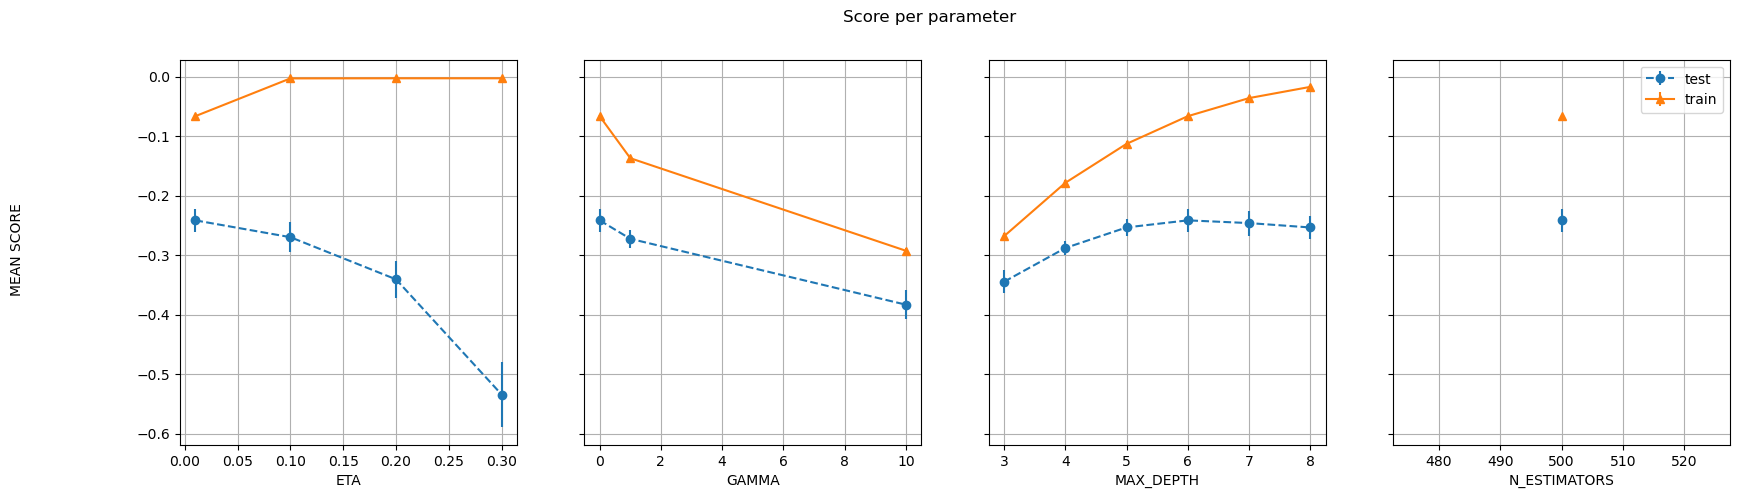

In [30]:
plot_gsearch_results(clf)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


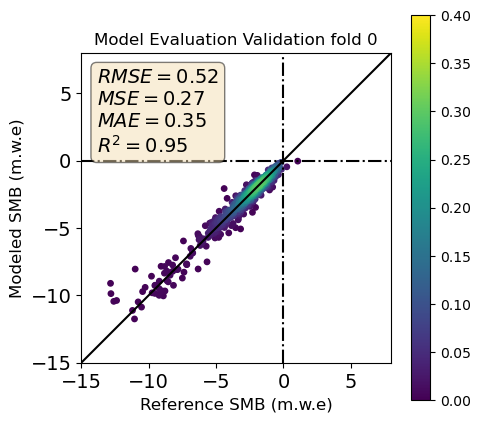

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


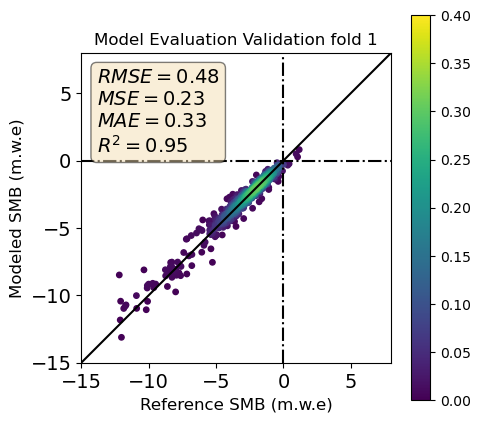

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


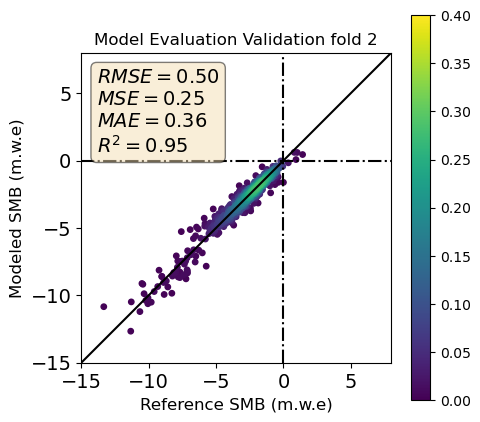

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


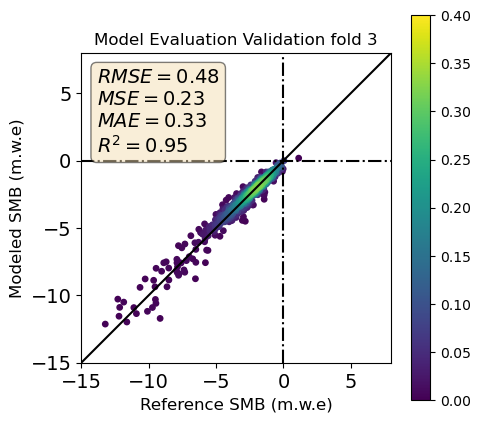

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


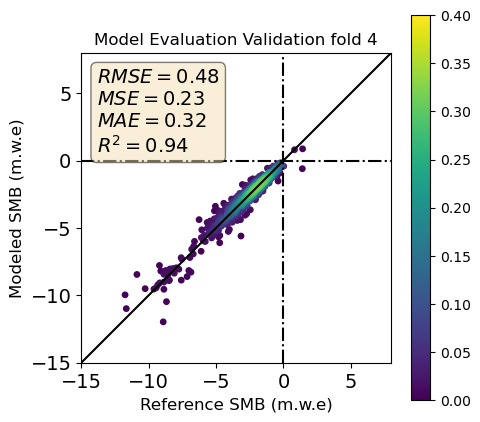

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


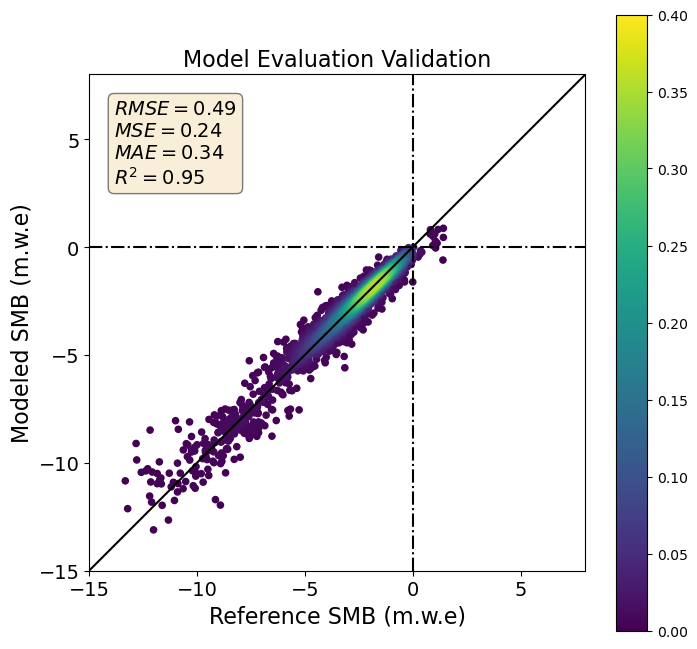

In [31]:
y_val_list = []
y_pred_list = []
i = 0

for train_index, val_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]
    fitted_model.fit(X_tr, y_tr)
    y_pred = fitted_model.predict(X_val)

    y_pred = y_pred.reshape(-1, 5).sum(axis=1)
    y_val = y_val.reshape(-1,5).mean(axis=1)
    
    y_val_list.extend(y_val)
    y_pred_list.extend(y_pred)

    title = 'Validation fold ' + str(i)

    plot_prediction(y_val, y_pred, title, n_toplot=10000, fold=True)

    i=i+1

    # Arrays of predictions and observations for each fold
    y_val_all = np.hstack([*y_val_list])
    y_pred_all = np.hstack([*y_pred_list])

# Plot predictions and observations for each cross-valiadation fold together
plot_prediction(y_val_all, y_pred_all, 'Validation', n_toplot=20000)

In [40]:
# Plot permutation importance
def plot_permutation_importance(df_train_X_s, X_train_s, y_train_s, splits_s, best_model, max_features_plot = 10):

    fig, ax = plt.subplots(1,5, figsize=(30,6))
    a = 0    
    for train_index, test_index in splits_s:
        # Loops over n_splits iterations and gets train and test splits in each fold
        X_train, X_test = X_train_s[train_index], X_train_s[test_index]
        y_train, y_test = y_train_s[train_index], y_train_s[test_index]

        best_model.fit(X_train, y_train)
    
        result = permutation_importance(best_model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=10)

        sorted_idx = result.importances_mean.argsort()
        labels = np.array(df_train_X_s.columns)[sorted_idx][-max_features_plot:]
    
        ax[a].boxplot(result.importances[sorted_idx].T[:,-max_features_plot:], vert=False, labels=labels)
        ax[a].set_title("Permutation Importance Fold " + str(a))

        a=a+1

    fig.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_5000\2687156945.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


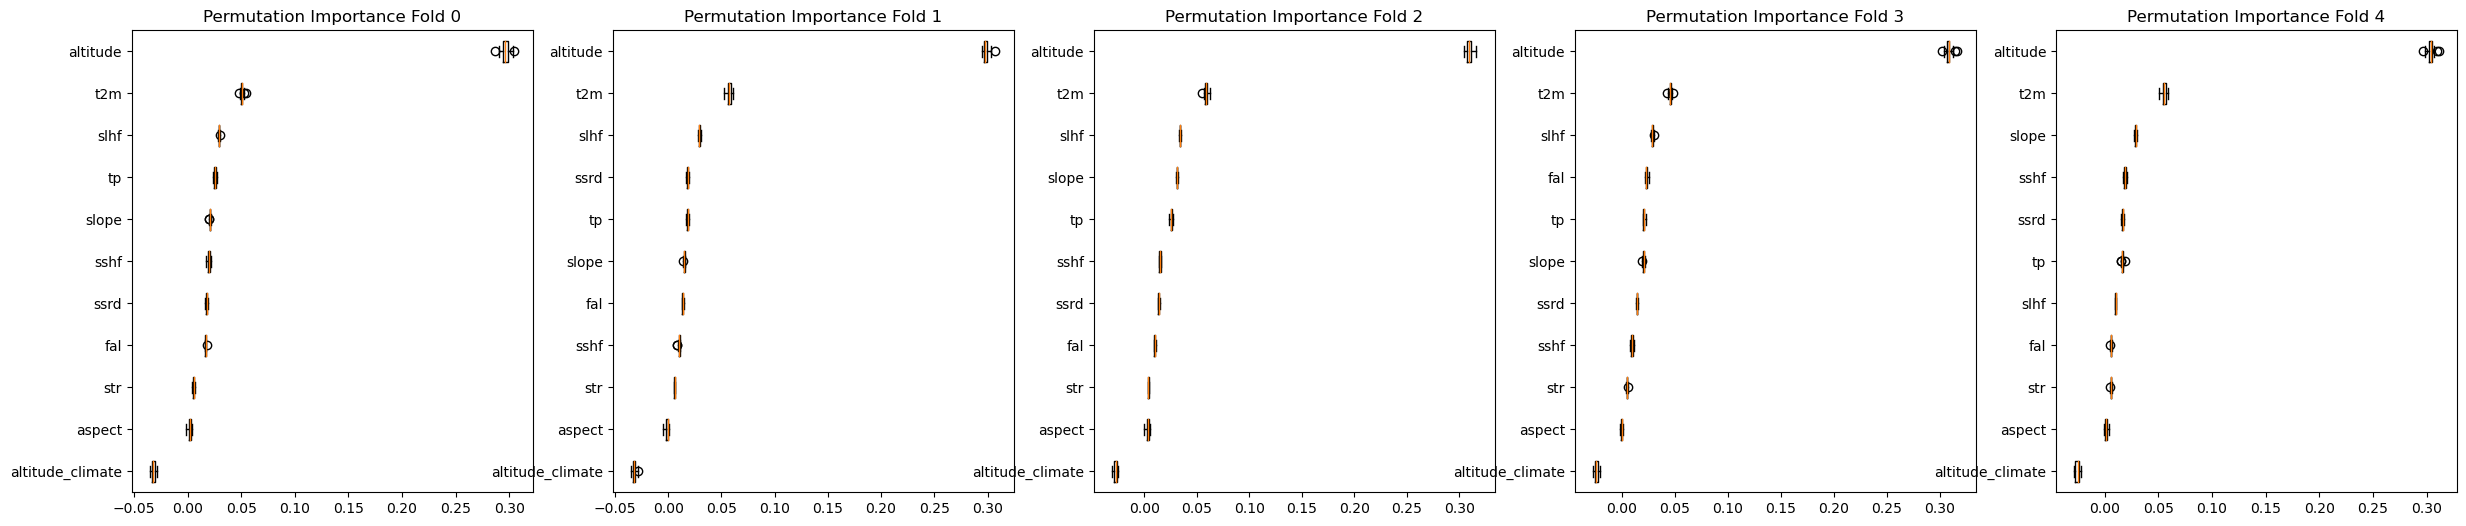

In [41]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

plot_permutation_importance(df_train_X, X_train, y_train, splits_s, fitted_model, max_features_plot = 20)

In [38]:
# Plot feature importance

max_features_plot = 10

fitted_model.fit(X_train, y_train)
feature_importance = fitted_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X.columns)[ind]





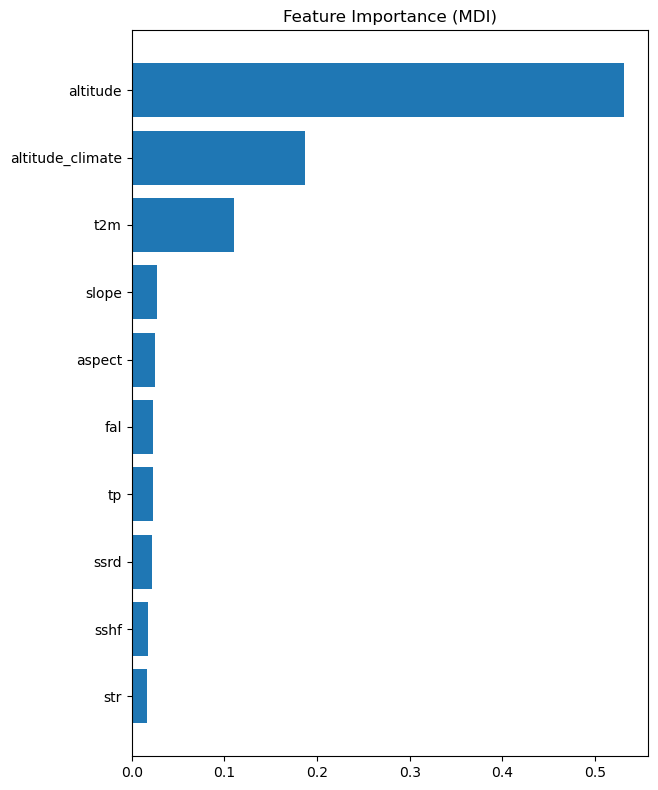

In [39]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


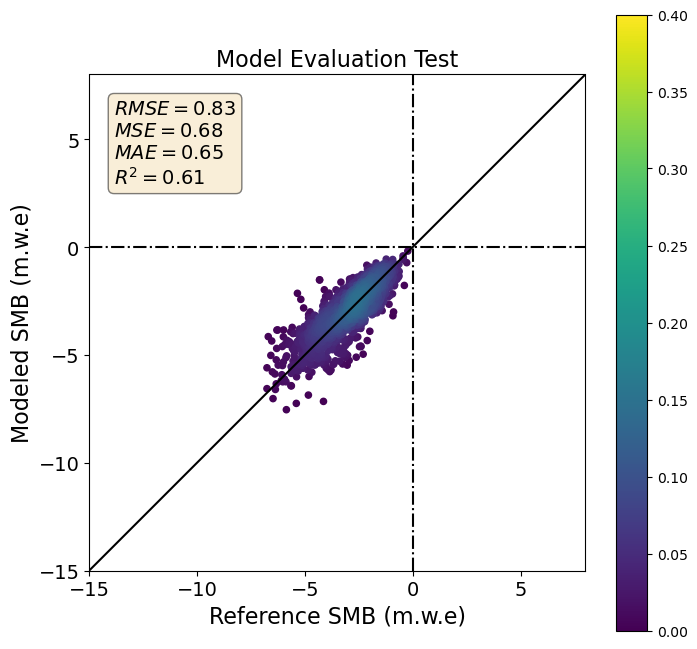

In [30]:
# Select features for testing
df_test_X = df_test_final.drop(['balance','BREID','n_months','month','id'], axis=1)

# Select labels for testing
df_test_y = df_test_final[['balance']]

# Get arrays of features and targets
X_test, y_test = df_test_X.values, df_test_y.values

fitted_model.fit(X_train, y_train)

preds_test = fitted_model.predict(X_test)
y_test_pred_sum = preds_test.reshape(-1, 5).sum(axis=1)
y_test_mean = y_test.reshape(-1,5).mean(axis=1)
plot_prediction(y_test_mean, y_test_pred_sum, data_type='Test')

### Test feature importance

In [64]:
# Train on full dataset and evaluate number of boosting rounds

# Convert to DMatrix
dtrain_full = xgb.DMatrix(X_train, label=y_train)

best_params_dict = {'max_depth': 4,
                   'eta': 0.1,
                   'gamma': 0}

# Train the model with early stopping to find the best number of boosting rounds
best_model = xgb.train(best_params_dict, dtrain_full, num_boost_round=500,
                       early_stopping_rounds=20, obj=seasonal_mse,
                       custom_metric=custom_mse,
                       evals=[(dtrain_full, 'full_data')], verbose_eval=False)

# The optimal number of boosting rounds
best_num_boost_round = best_model.best_iteration
print("Best Number of Boosting Rounds:", best_num_boost_round)

#test_model = cv_grid.best_estimator_
#test_model.fit(X_train, y_train)
y_pred_full = best_model.predict(dtrain_full)

y_pred_sum = y_pred_full.reshape(-1, 5).sum(axis=1)
print(y_pred_sum.shape)

y_train_full = dtrain_full.get_label()
y_train_mean = y_train_full.reshape(-1,5).mean(axis=1)
print(y_train_mean.shape)

plot_prediction(y_train_mean, y_pred_sum, data_type='Validation')

dtest = xgb.DMatrix(X_test)
preds_test = best_model.predict(dtest)
y_test_pred_sum = preds_test.reshape(-1, 5).sum(axis=1)
y_test_mean = y_test.reshape(-1,5).mean(axis=1)
plot_prediction(y_test_mean, y_test_pred_sum, data_type='Test')

preds = model.predict(dtrain)
print(preds[:5])
print(preds[:5].sum())
print(y_train[0])

Best Number of Boosting Rounds: 499


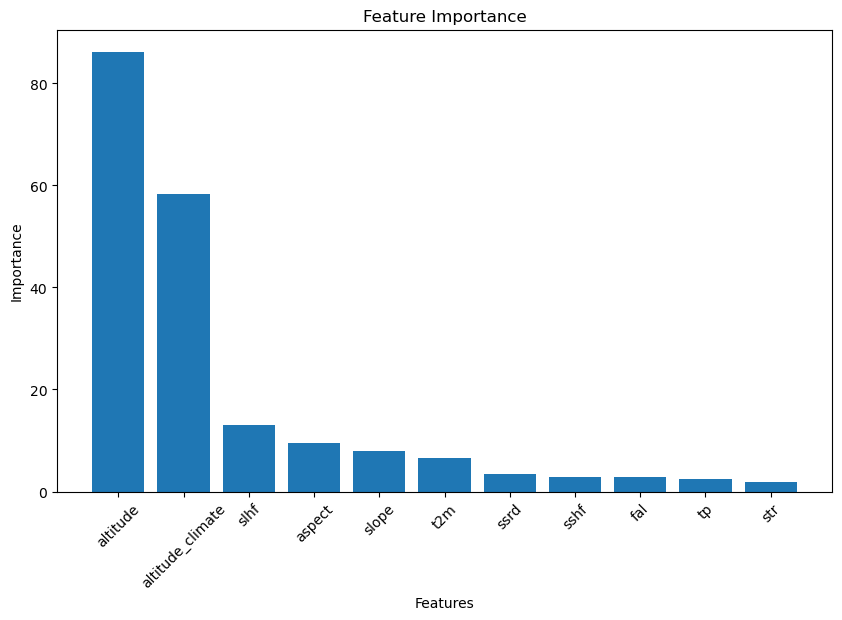

In [118]:
# Feature importance: gain
#Gain:
#Description: Gain measures the average gain of a feature when it is used in trees. The gain is a measure of the improvement in accuracy brought by a feature to the branches it is on.
#Interpretation: A higher gain value when a feature is used implies the feature is more useful for improving the model's performance. Gain is a more nuanced metric compared to weight, as it takes into account the effectiveness of each feature in improving the model.
#Use Case: This is often considered the most important metric, as it gives a clearer indication of the contribution of each feature to the model's predictive power.

# Get the feature names from the DataFrame
feature_names = df_train_X.columns

# Map 'f0', 'f1', etc. to actual feature names
fmap = {f'f{i}': name for i, name in enumerate(feature_names)}

# Get feature importance and map feature names
feature_importance = model.get_score(importance_type='gain')
feature_importance = {fmap[k]: v for k, v in feature_importance.items()}

# Sorting the features based on importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

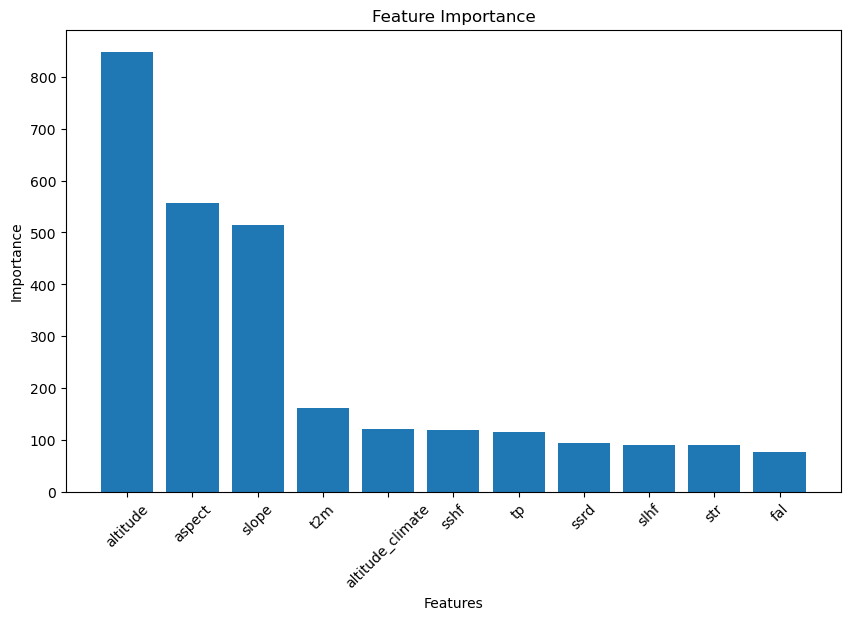

In [119]:
# Feature importance: weight
#Weight (Frequency):
#Description: This metric counts the number of times a feature is used to split the data across all trees.
#Interpretation: A feature with a higher weight has been used more often in decision nodes of trees. This indicates it's generally more important for making splits, but doesn't necessarily imply a strong predictive power.
#Use Case: Useful for understanding which features are frequently considered in the model's decision-making process.

# Get the feature names from the DataFrame
feature_names = df_train_X.columns

# Map 'f0', 'f1', etc. to actual feature names
fmap = {f'f{i}': name for i, name in enumerate(feature_names)}

# Get feature importance and map feature names
feature_importance = model.get_score(importance_type='weight')
feature_importance = {fmap[k]: v for k, v in feature_importance.items()}

# Sorting the features based on importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

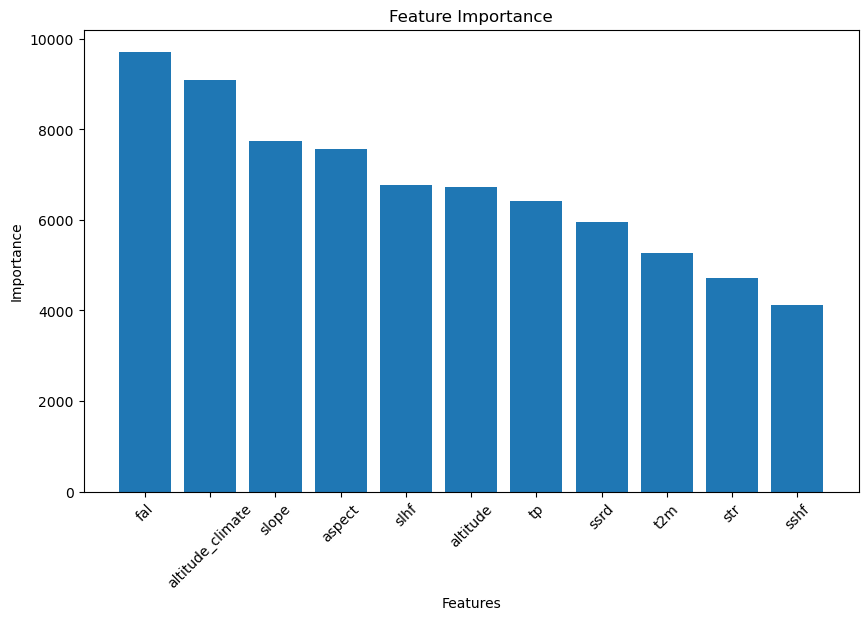

In [105]:
# Feature importance cover: 
#Cover:
#Description: Cover measures the average coverage of a feature when it is used in trees. Coverage is defined as the number of samples affected by the split.
#Interpretation: A higher cover value indicates that the feature is used in splits that affect more samples. It gives an idea of the range of influence of the feature in the dataset.
#Use Case: Useful for understanding the impact of a feature on the data distribution in the model.

# Get the feature names from the DataFrame
feature_names = df_train_X.columns

# Map 'f0', 'f1', etc. to actual feature names
fmap = {f'f{i}': name for i, name in enumerate(feature_names)}

# Get feature importance and map feature names
feature_importance = model.get_score(importance_type='cover')
feature_importance = {fmap[k]: v for k, v in feature_importance.items()}

# Sorting the features based on importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# Model training with annual, summer and winter mass balance

## Prepare training data

In [2]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_15760\398696404.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [3]:
# Manually select test glaciers (14 glaciers)
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

# Get test dataset for each of annual, winter and summer mass balance
df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3133 has 38 points
# 3137 has 65 points
# 3138 has 6 points
# 3141 has 72 points

# Get training dataset for each of annual, winter and summer mass balance
df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=7
df_train_summer['n_months']=5
df_test_annual['n_months']=12
df_test_winter['n_months']=7
df_test_summer['n_months']=5

print(f'Train/test annual: {len(df_train_annual)}/{len(df_test_annual)}')
print(f'Train/test winter: {len(df_train_winter)}/{len(df_test_winter)}')
print(f'Train/test summer: {len(df_train_summer)}/{len(df_test_summer)}')
print(f'All train/test: {len(df_train_annual)+len(df_train_winter)+len(df_train_summer)} / {len(df_test_annual)+len(df_test_winter)+len(df_test_summer)}')
print(f'Fraction train/test: {(len(df_train_annual)+len(df_train_winter)+len(df_train_summer)) / (len(df_test_annual)+len(df_test_winter)+len(df_test_summer)+len(df_train_annual)+len(df_train_winter)+len(df_train_summer))} / {(len(df_test_annual)+len(df_test_winter)+len(df_test_summer)) /(len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer))}')
print(f'Total entries: {len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer)}')


Train/test annual: 2845/1065
Train/test winter: 2752/1000
Train/test summer: 2901/1028
All train/test: 8498 / 3093
Fraction train/test: 0.7331550340781641 / 0.26684496592183593
Total entries: 11591


C:\Users\kasj\AppData\Local\Temp\ipykernel_15760\1367612944.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_15760\1367612944.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=7
C:\Users\kasj\AppData\Local\Temp\ipykernel_15760\1367612944.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [4]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
#sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
#f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
#df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])

In [5]:
df_train_summer_clean = df_train_summer_clean.dropna(axis=1, how='all')
df_train_winter_clean = df_train_winter_clean.dropna(axis=1, how='all')
df_train_annual_clean = df_train_annual_clean.dropna(axis=1, how='all')
#df_train_summer_clean.reset_index(drop=True, inplace=True)

n_summer = len(df_train_summer_clean)
n_winter = len(df_train_winter_clean)
n_annual = len(df_train_annual_clean)

df_train_summer_clean.insert(0, 'id', list(range(n_summer)))
df_train_winter_clean.insert(0, 'id', list(range(n_summer, n_summer+n_winter)))
df_train_annual_clean.insert(0, 'id', list(range(n_summer+n_winter, n_summer+n_winter+n_annual)))


In [6]:
df_train_annual_clean

,id,BREID,altitude,balance,aspect,slope,t2m_oct,t2m_nov,t2m_dec,t2m_jan,...,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,year,n_months
189,5653,596,990.0,-1.76,2.509464,0.238202,269.201416,264.435547,258.228821,258.308533,...,0.002447,0.003016,0.001702,0.001953,0.004025,0.002591,0.006047,1001.181943,1963,12
190,5654,596,996.0,-0.30,2.474161,0.117946,269.387421,261.827911,262.573364,265.326019,...,0.002428,0.001993,0.002906,0.003402,0.003066,0.004062,0.004951,1001.181943,1964,12
191,5655,596,988.0,-2.18,2.509464,0.238202,270.417572,259.927002,254.755005,255.577148,...,0.003090,0.001900,0.003094,0.001567,0.003896,0.004033,0.004845,1001.181943,1966,12
192,5656,596,990.0,-1.68,2.478294,0.146882,267.011292,265.178741,258.606110,257.204742,...,0.003645,0.003376,0.000861,0.004021,0.006549,0.003302,0.003687,1001.181943,1967,12
193,5657,596,990.0,-0.31,2.478294,0.146882,267.775757,267.829651,256.208740,254.525742,...,0.004874,0.004694,0.001514,0.004824,0.003683,0.004470,0.001097,1001.181943,1968,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3724,8493,3129,1551.0,0.90,2.115165,0.111223,273.632507,271.576019,266.273407,264.191864,...,0.012723,0.002380,0.003067,0.004948,0.001373,0.001677,0.008620,994.833212,1968,12
3725,8494,3129,1571.0,0.91,2.312361,0.097301,273.717529,268.352692,263.543549,266.749390,...,0.000360,0.005509,0.005468,0.009837,0.010945,0.007251,0.008933,994.833212,1964,12
3726,8495,3129,1587.0,0.19,2.482095,0.070551,272.888550,269.671326,264.862183,262.965088,...,0.003609,0.002511,0.001531,0.006192,0.002394,0.006272,0.007284,994.833212,1965,12
3727,8496,3129,1590.0,-1.11,2.339748,0.073072,276.245483,262.063232,260.118317,258.969757,...,0.008622,0.002017,0.004337,0.003802,0.004859,0.004397,0.011932,994.833212,1966,12


In [7]:
# Columns that are not monthly climate variables (identifiers and static variables)
id_vars = ['id','BREID', 'year', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
summer_months_order = ['may', 'jun', 'jul', 'aug', 'sep']
winter_months_order = ['oct','nov','dec','jan','feb','mar','apr']
annual_months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

def reshape_dataset_monthly(df, id_vars, variables, months_order): 
    # Prepare a list to hold the reshaped DataFrames for each variable
    df_list = []

    for var in variables:
        # Filter columns for the current variable and the ID columns
        cols = [col for col in df.columns if col.startswith(var) or col in id_vars]
        df_var = df[cols]

        # Rename the columns to have just the month
        df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

        # Melt the DataFrame to long format and add month order
        df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
        df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

        # Append the reshaped DataFrame to the list
        df_list.append(df_melted)

    # Combine all reshaped DataFrames
    df_final = df_list[0]
    for df_temp in df_list[1:]:
        df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='left')

    # Sort the DataFrame based on ID variables and month
    df_final = df_final.sort_values(by=id_vars + ['month'])

    return(df_final)

df_train_summer_final = reshape_dataset_monthly(df_train_summer_clean, id_vars, variables, summer_months_order)
df_train_winter_final = reshape_dataset_monthly(df_train_winter_clean, id_vars, variables, winter_months_order)
df_train_annual_final = reshape_dataset_monthly(df_train_annual_clean, id_vars, variables, annual_months_order)


In [8]:
df_train_summer_final

,id,BREID,year,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
2901,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
5802,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
8703,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
11604,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2900,2900,3129,1967,1587.0,-1.19,2.526225,0.068208,994.833212,5,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
5801,2900,3129,1967,1587.0,-1.19,2.526225,0.068208,994.833212,5,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
8702,2900,3129,1967,1587.0,-1.19,2.526225,0.068208,994.833212,5,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
11603,2900,3129,1967,1587.0,-1.19,2.526225,0.068208,994.833212,5,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [9]:
df_train_summer_final.reset_index(drop=True, inplace=True)
df_train_winter_final.reset_index(drop=True, inplace=True)
df_train_annual_final.reset_index(drop=True, inplace=True)


In [10]:
data_list = [df_train_summer_final, df_train_winter_final, df_train_annual_final]
df_train_final = pd.concat(data_list)
df_train_final

,id,BREID,year,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
1,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
2,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
3,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
4,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34135,8497,3129,1967,1587.0,1.58,2.526225,0.068208,994.833212,12,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
34136,8497,3129,1967,1587.0,1.58,2.526225,0.068208,994.833212,12,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
34137,8497,3129,1967,1587.0,1.58,2.526225,0.068208,994.833212,12,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
34138,8497,3129,1967,1587.0,1.58,2.526225,0.068208,994.833212,12,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


## Prepare test data

In [11]:
# Prepare test

# Select features for training
df_test_annual_clean = df_test_annual.drop(drop_cols, axis=1)
df_test_winter_clean = df_test_winter.drop(drop_cols, axis=1)
df_test_summer_clean = df_test_summer.drop(drop_cols, axis=1)
df_test_annual_clean = df_test_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_test_winter_clean = df_test_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_test_summer_clean = df_test_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_test_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_test_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
#df_test_all = pd.concat([df_test_annual_clean, df_test_summer_clean, df_test_winter_clean])
#df_test_all.reset_index(drop=True, inplace=True)


In [12]:
df_test_summer_clean = df_test_summer_clean.dropna(axis=1, how='all')
df_test_winter_clean = df_test_winter_clean.dropna(axis=1, how='all')
df_test_annual_clean = df_test_annual_clean.dropna(axis=1, how='all')

n_summer = len(df_test_summer_clean)
n_winter = len(df_test_winter_clean)
n_annual = len(df_test_annual_clean)

df_test_summer_clean.insert(0, 'id', list(range(n_summer)))
df_test_winter_clean.insert(0, 'id', list(range(n_summer, n_summer+n_winter)))
df_test_annual_clean.insert(0, 'id', list(range(n_summer+n_winter, n_summer+n_winter+n_annual)))


In [13]:
df_test_winter_clean

,id,BREID,altitude,balance,aspect,slope,t2m_oct,t2m_nov,t2m_dec,t2m_jan,...,tp_nov,tp_dec,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,altitude_climate,year,n_months
0,1028,54,471.0,1.32,0.629597,0.278773,272.721558,268.369415,261.676819,265.982666,...,0.003902,0.000812,0.005081,0.005116,0.002688,0.002334,0.001159,341.227919,2013,7
1,1029,54,439.0,1.68,0.585924,0.296590,272.114990,266.221802,267.242828,262.563507,...,0.004794,0.004194,0.000121,0.001831,0.004597,0.005634,0.002244,341.227919,2014,7
2,1030,54,444.0,0.76,0.663261,0.302508,272.699524,267.655823,264.615448,261.710236,...,0.002804,0.002613,0.001190,0.004949,0.003286,0.003739,0.004709,341.227919,2015,7
3,1031,54,444.0,0.78,0.663261,0.302508,273.610504,268.402802,266.645386,261.301056,...,0.003998,0.005511,0.001945,0.002495,0.002263,0.001256,0.002129,341.227919,2016,7
4,1032,54,468.0,1.59,0.836757,0.309196,275.042999,267.983765,268.339783,265.597778,...,0.001798,0.006462,0.004863,0.003314,0.004417,0.002704,0.003991,341.227919,2017,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747,2023,3141,1078.0,1.50,2.906044,0.131717,275.153076,274.064453,268.199371,267.307373,...,0.011941,0.015777,0.009134,0.011964,0.007288,0.003555,0.005019,917.419759,2012,7
3748,2024,3141,1078.0,1.14,2.906044,0.131717,272.392090,271.474274,263.463837,265.285767,...,0.012002,0.007372,0.005585,0.002572,0.000807,0.009360,0.006135,917.419759,2013,7
3749,2025,3141,1079.0,1.19,2.906044,0.131717,277.258179,272.374634,268.646484,268.628265,...,0.005951,0.014222,0.017394,0.008543,0.010311,0.006261,0.008175,917.419759,2015,7
3750,2026,3141,1078.0,1.72,2.906044,0.131717,276.456512,272.113464,270.930725,263.854034,...,0.014949,0.020667,0.007431,0.008916,0.003751,0.004573,0.004449,917.419759,2016,7


In [14]:
# Columns that are not monthly climate variables (identifiers and static variables)
id_vars = ['id','BREID', 'year', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
summer_months_order = ['may', 'jun', 'jul', 'aug', 'sep']
winter_months_order = ['oct','nov','dec','jan','feb','mar','apr']
annual_months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

def reshape_dataset_monthly(df, id_vars, variables, months_order): 
    # Prepare a list to hold the reshaped DataFrames for each variable
    df_list = []

    for var in variables:
        # Filter columns for the current variable and the ID columns
        cols = [col for col in df.columns if col.startswith(var) or col in id_vars]
        df_var = df[cols]

        # Rename the columns to have just the month
        df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

        # Melt the DataFrame to long format and add month order
        df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
        df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

        # Append the reshaped DataFrame to the list
        df_list.append(df_melted)

    # Combine all reshaped DataFrames
    df_final = df_list[0]
    for df_temp in df_list[1:]:
        df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='left')

    # Sort the DataFrame based on ID variables and month
    df_final = df_final.sort_values(by=id_vars + ['month'])

    return(df_final)

df_test_summer_final = reshape_dataset_monthly(df_test_summer_clean, id_vars, variables, summer_months_order)
df_test_winter_final = reshape_dataset_monthly(df_test_winter_clean, id_vars, variables, winter_months_order)
df_test_annual_final = reshape_dataset_monthly(df_test_annual_clean, id_vars, variables, annual_months_order)


In [15]:
df_test_summer_final

,id,BREID,year,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,54,2013,471.0,-6.24,0.629597,0.278773,341.227919,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1028,0,54,2013,471.0,-6.24,0.629597,0.278773,341.227919,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2056,0,54,2013,471.0,-6.24,0.629597,0.278773,341.227919,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3084,0,54,2013,471.0,-6.24,0.629597,0.278773,341.227919,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4112,0,54,2013,471.0,-6.24,0.629597,0.278773,341.227919,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,1027,3141,2017,1078.0,-4.44,2.906044,0.131717,917.419759,5,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
2055,1027,3141,2017,1078.0,-4.44,2.906044,0.131717,917.419759,5,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
3083,1027,3141,2017,1078.0,-4.44,2.906044,0.131717,917.419759,5,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
4111,1027,3141,2017,1078.0,-4.44,2.906044,0.131717,917.419759,5,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


In [16]:
df_test_summer_final.reset_index(drop=True, inplace=True)
df_test_winter_final.reset_index(drop=True, inplace=True)
df_test_annual_final.reset_index(drop=True, inplace=True)

In [17]:
data_list = [df_test_summer_final, df_test_winter_final, df_test_annual_final]
df_test_final = pd.concat(data_list)
df_test_final

,id,BREID,year,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,54,2013,471.0,-6.24,0.629597,0.278773,341.227919,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1,0,54,2013,471.0,-6.24,0.629597,0.278773,341.227919,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2,0,54,2013,471.0,-6.24,0.629597,0.278773,341.227919,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3,0,54,2013,471.0,-6.24,0.629597,0.278773,341.227919,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4,0,54,2013,471.0,-6.24,0.629597,0.278773,341.227919,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12775,3092,3141,2017,1078.0,-3.29,2.906044,0.131717,917.419759,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
12776,3092,3141,2017,1078.0,-3.29,2.906044,0.131717,917.419759,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
12777,3092,3141,2017,1078.0,-3.29,2.906044,0.131717,917.419759,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
12778,3092,3141,2017,1078.0,-3.29,2.906044,0.131717,917.419759,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


%## Define custom loss and evaluation functions

In [18]:
# # Define custom objective function (used in model training) for XGBoost Scikit learn interface

# # When defining a custom loss function with the Scikit learn XGBoost api, input arguments
# # are (targets, predictions). 
# def seasonal_mse_sklearn(y_true, y_pred):
#     """
#     Custom Mean Squared Error objective function for seasonal data.
#     XGBoost Scikit learn api.

#     """

#     # Assuming 5-month seasons, reshape predictions and true values
#     y_pred_seasonal = y_pred.reshape(-1, 5)
#     y_true_seasonal = y_true.reshape(-1, 5)

#     # Aggregate predictions and true values over the season
#     # Predictions are summed over months, true values are repeated so mean is taken
#     y_pred_agg = np.sum(y_pred_seasonal, axis=1)
#     y_true_agg = np.mean(y_true_seasonal, axis=1)

#     # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
#     gradient = y_pred_agg - y_true_agg
#     hessian = np.ones_like(gradient)

#     # Reshape gradient and hessian to match the original shape
#     gradient = np.repeat(gradient, 5)
#     hessian = np.repeat(hessian, 5)

#     return gradient, hessian

# # Define custom evaluation function for XGBoost Scikit learn api (used in cross-validation) 
# # This function is not used in training, but is used in evaluating the predictions
# # from the trained model. 
# def custom_mse_eval_sklearn(y_val, y_pred):
#     """
#     Custom Mean Squared Error evaluation function for seasonal data.
#     XGBoost Scikit learn api.
#     """
    
#     # Aggregate predicted and true monthly over the season.
#     y_pred_agg = y_pred.reshape(-1, 5).sum(axis=1)
#     y_val_mean = y_val.reshape(-1,5).mean(axis=1)

#     # Compute mean squared error between predictions and observations
#     error = y_pred_agg - y_val_mean
#     squared_error = np.square(error)
#     mse = np.mean(squared_error)

#     return mse
    

In [19]:
# # Custom objective function scikit learn api with additional arguments
# # Example:
# # def focal_loss(alpha, gamma):
# #     def custom_loss(y_pred, y_true):
# #         a,g = alpha, gamma
# #         def fl(x,t):
# #             p = 1/(1+np.exp(-x))
# #             return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
# #         partial_fl = lambda x: fl(x, y_true)
# #         grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
# #         hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
# #         return grad, hess
# #     return custom_loss

# # xgb = xgb.XGBClassifier(objective=focal_loss(alpha=0.25, gamma=1))
# def seasonal_loss(months):
#     def seasonal_mse_sklearn(y_true, y_pred):
#         """
#         Custom Mean Squared Error objective function for seasonal data.
#         XGBoost Scikit learn api.
    
#         """
#         n = months
        
#         # Assuming 5-month seasons, reshape predictions and true values
#         y_pred_seasonal = y_pred.reshape(-1, n)
#         y_true_seasonal = y_true.reshape(-1, n)

#         # Aggregate predictions and true values over the season
#         # Predictions are summed over months, true values are repeated so mean is taken
#         y_pred_agg = np.sum(y_pred_seasonal, axis=1)
#         y_true_agg = np.mean(y_true_seasonal, axis=1)

#         # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
#         gradient = y_pred_agg - y_true_agg
#         hessian = np.ones_like(gradient)

#         # Reshape gradient and hessian to match the original shape
#         gradient = np.repeat(gradient, n)
#         hessian = np.repeat(hessian, n)

#         return gradient, hessian
#     return seasonal_mse_sklearn

## Split training data for cross-validation

In [20]:
df_train_final

,id,BREID,year,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
1,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
2,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
3,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
4,0,596,1963,990.0,-3.41,2.509464,0.238202,1001.181943,5,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34135,8497,3129,1967,1587.0,1.58,2.526225,0.068208,994.833212,12,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
34136,8497,3129,1967,1587.0,1.58,2.526225,0.068208,994.833212,12,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
34137,8497,3129,1967,1587.0,1.58,2.526225,0.068208,994.833212,12,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
34138,8497,3129,1967,1587.0,1.58,2.526225,0.068208,994.833212,12,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [21]:
# Select features for training
df_train_X_reduce = df_train_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]


In [22]:
# id, n_months and months are moved to the end of the dataframe and will be used as metadata (not as features in training)
df_train_X

,altitude,aspect,slope,altitude_climate,t2m,sshf,slhf,ssrd,fal,str,tp,id,n_months,month
0,990.0,2.509464,0.238202,1001.181943,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702,0,5,may
1,990.0,2.509464,0.238202,1001.181943,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953,0,5,jun
2,990.0,2.509464,0.238202,1001.181943,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025,0,5,jul
3,990.0,2.509464,0.238202,1001.181943,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591,0,5,aug
4,990.0,2.509464,0.238202,1001.181943,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047,0,5,sep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34135,1587.0,2.526225,0.068208,994.833212,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908,8497,12,may
34136,1587.0,2.526225,0.068208,994.833212,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480,8497,12,jun
34137,1587.0,2.526225,0.068208,994.833212,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605,8497,12,jul
34138,1587.0,2.526225,0.068208,994.833212,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391,8497,12,aug


In [23]:
# Select labels for training
df_train_y = df_train_final[['balance']]

# df_train_y contains seasonal and annual mass balance, in the same order as df_train_X
df_train_y

,balance
0,-3.41
1,-3.41
2,-3.41
3,-3.41
4,-3.41
...,...
34135,1.58
34136,1.58
34137,1.58
34138,1.58


In [24]:
# Get arrays of features+metadata and targets
X_train, y_train = df_train_X.values, df_train_y.values

In [25]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_final['id'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train, y_train, gp_s))

#print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
#print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
#print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
#print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
#print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
#print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
#print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
#print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
#print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
#print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))
print(len(gp_s))
print(y_train.shape)
print(X_train.shape)

67909
(67909, 1)
(67909, 14)


In [26]:
# Check folds
fold_indices = []

for train_index, test_index in group_kf.split(X_train, y_train, gp_s):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("shape(train):", train_index.shape, "test:", test_index.shape)
    fold_indices.append((train_index, test_index))


TRAIN: [    0     1     2 ... 67894 67895 67896] TEST: [   15    16    17 ... 67906 67907 67908]
shape(train): (54329,) test: (13580,)
TRAIN: [    0     1     2 ... 67906 67907 67908] TEST: [   10    11    12 ... 67858 67859 67860]
shape(train): (54329,) test: (13580,)
TRAIN: [    0     1     2 ... 67906 67907 67908] TEST: [    5     6     7 ... 67846 67847 67848]
shape(train): (54326,) test: (13583,)
TRAIN: [    0     1     2 ... 67906 67907 67908] TEST: [   25    26    27 ... 67834 67835 67836]
shape(train): (54326,) test: (13583,)
TRAIN: [    5     6     7 ... 67906 67907 67908] TEST: [    0     1     2 ... 67894 67895 67896]
shape(train): (54326,) test: (13583,)


In [101]:
# Select features for training
df_test_X_reduce = df_test_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_test_X = df_test_X_reduce[[c for c in df_test_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_test_y = df_test_final[['balance']]

In [105]:
# Get arrays of features+metadata and targets
X_test, y_test = df_test_X.values, df_test_y.values

## Define custom XGBRegressor class and objective/loss function

#### Custom objective/loss function to be used with custom XGBRegressor class

In [207]:
# Custom objective function scikit learn api with metadata

def custom_mse_metadata(y_true, y_pred, metadata):
    """
    Custom Mean Squared Error (MSE) objective function for evaluating monthly predictions with respect to 
    seasonally or annually aggregated observations.
    
    For use in cases where predictions are done on a monthly time scale and need to be aggregated to be
    compared with the true aggregated seasonal or annual value. Aggregations are performed according to a
    unique ID provided by metadata. The function computes gradients and hessians 
    used in gradient boosting methods, specifically for use with the XGBoost library's custom objective 
    capabilities.
    
    Parameters
    ----------
    y_true : numpy.ndarray
        True (seasonally or annually aggregated) values for each instance. For a unique ID, 
        values are repeated n_months times across the group, e.g. the annual mass balance for a group
        of 12 monthly predictions with the same unique ID is repeated 12 times. Before calculating the 
        loss, the mean over the n unique IDs is taken.
    
    y_pred : numpy.ndarray
        Predicted monthly values. These predictions will be aggregated according to the 
        unique ID before calculating the loss, e.g. 12 monthly predictions with the same unique ID is
        aggregated for evaluation against the true annual value.
    
    metadata : numpy.ndarray
        An ND numpy array containing metadata for each monthly prediction. The first column is mandatory 
        and represents the ID of the aggregated group to which each instance belongs. Each group identified 
        by a unique ID will be aggregated together for the loss calculation. The following columns in the 
        metadata can include additional information for each instance that may be useful for tracking or further 
        processing but are not used in the loss calculation, e.g. number of months to be aggregated or the name 
        of the month.
        
        ID (column 0): An integer that uniquely identifies the group which the instance belongs to.
            
    Returns
    -------
    gradients : numpy.ndarray
        The gradient of the loss with respect to the predictions y_pred. This array has the same shape 
        as y_pred.
    
    hessians : numpy.ndarray
        The second derivative (hessian) of the loss with respect to the predictions y_pred. For MSE loss, 
        the hessian is constant and thus this array is filled with ones, having the same shape as y_pred.
    """
    
    # Initialize empty arrays for gradient and hessian
    gradients = np.zeros_like(y_pred)
    hessians = np.ones_like(y_pred) # Ones in case of mse
    
    # Unique aggregation groups based on the aggregation ID
    unique_ids = np.unique(metadata[:, 0])
    
    # Loop over each unique ID to aggregate accordingly
    for uid in unique_ids:
        # Find indexes for the current aggregation group
        indexes = metadata[:, 0] == uid
        
        # Aggregate y_pred for the current group
        y_pred_agg = np.sum(y_pred[indexes])
        
        # True value is the same repeated value for the group, so we can use the mean
        y_true_mean = np.mean(y_true[indexes])
        
        # Compute gradients for the group based on the aggregated prediction
        gradient = y_pred_agg - y_true_mean
        gradients[indexes] = gradient

    return gradients, hessians


#### Test custom loss with dummy data

In [28]:
# Create dummy data for test

np.random.seed(42)

n_groups = 10  # Number of unique groups 
group_sizes = [5, 6, 12]
n_samples = n_groups * group_sizes[0] + n_groups * group_sizes[1] + n_groups * group_sizes[2]

# Generate n_samples/n_groups random true season/annual values
seasonal_values = 5*np.random.rand(n_groups*len(group_sizes))

# Repeat each true value according to its group size and randomly shuffle it
y_true = np.hstack([np.repeat(val, size) for val, size in zip(seasonal_values, np.repeat(group_sizes,n_groups))])
y_true = np.random.permutation(y_true)

# Generate random monthly predictions with some noise
y_pred = y_true/10 + np.random.normal(0, 0.1, size=n_samples)

# Create metadata: each group has an ID and a size indicator
metadata = np.vstack([
    np.column_stack((np.full(size, i, dtype=int), 
                     np.full(size, size, dtype=int)))
    for i, size in enumerate(np.repeat(group_sizes,n_groups))
])

# Shuffle metadata in the same way as y_true
p = np.random.permutation(n_samples)
metadata = metadata[p]


In [29]:
# Run custom loss calculations (test based on id being first column in metadata)

# Initialize empty arrays for gradient and hessian
gradients = np.zeros_like(y_pred)
hessians = np.ones_like(y_pred) # Ones in case of mse
    
# Unique aggregation groups based on the aggregation ID
unique_ids = np.unique(metadata[:, 0])
    
# Loop over each unique ID to aggregate accordingly
for uid in unique_ids:
    # Find indexes for the current aggregation group
    indexes = metadata[:, 0] == uid
        
    # Aggregate y_pred for the current group, e.g., take a mean of the predictions
    y_pred_agg = np.sum(y_pred[indexes])
        
    # True value is the same repeated value for the group, so we can take the first
    y_true_mean = np.mean(y_true[indexes])
        
    # Compute gradients for the group based on the aggregated prediction
    gradient = y_pred_agg - y_true_mean
    gradients[indexes] = gradient

    #print(uid)
    #print(y_pred[indexes].shape)
    #print(y_true[indexes].shape)
#print(gradients.shape)

#### OLD custom estimator: Custom estimator class based on BaseEstimator and RegressorMixin from Scikitlearn

Works for fit and predict, but not set up to use with grid search.

In [30]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.datasets import make_regression
from sklearn.utils.validation import check_is_fitted

class CustomRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth=3, learning_rate=0.1, n_estimators=100, gamma=0):
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.gamma = gamma

    def fit(self, X, y, **kwargs):
        # Extract metadata and features. The last three columns of X is metadata (id, n_months, month).
        metadata = X[:, -3:]
        features = X[:, :-3]

        # Define training matrix.
        dtrain = xgb.DMatrix(features, label=y)

        # Set up booster parameters
        params = {
            'max_depth': self.max_depth,
            'eta': self.learning_rate,
            'gamma': self.gamma}

        # Create closure that encapsulates metadata.
        # XGBoost objective function accepts two parameters (y_pred, dtrain)
        # Scikit learn objective function accepts two parameters (y_true, y_pred)
        def objective_closure(y_pred, dtrain):
            y_true = dtrain.get_label()
            grad, hess = custom_mse_metadata(y_true, y_pred, metadata)
            return grad, hess
            
        # Train the model
        self.model_ = xgb.train(
            params, 
            dtrain=dtrain,
            num_boost_round=self.n_estimators, 
            obj=objective_closure, 
            **kwargs
        )

        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self, 'model_')
        
        features = X[:, :-3]
        dval = xgb.DMatrix(features)
        return self.model_.predict(dval)

    def get_params(self, deep=True):
        # Necessary for grid search to work properly
        return {k: getattr(self, k) for k in self._get_param_names()}

    def set_params(self, **params):
        # Necessary for grid search to work properly
        #self.params.update(params)
        super().set_params(**params)
        return self
        

#### Custom estimator class based on XGBRegressor

Inherits from xgboost.XGBRegressor 

Note/to-do: Modify def __init__(self,..) to retrieve kwarg for number of columns of metadata (n_metadata) with default n_metadata=None, to allow for flexibility in the number of metadata columns.

In [240]:
# from xgboost import XGBRegressor

# class CustomXGBRegressor(XGBRegressor):
#     """
#     CustomXGBRegressor is an extension of the XGBoost regressor that
#     incorporates additional metadata into the learning process. The estimator
#     is tailored to handle training datasets where the last three columns are
#     metadata rather than features.

#     The metadata is utilized in a custom mean squared error function.
#     This function calculates gradients and
#     hessians incorporating metadata, allowing the model to learn from both
#     standard feature data and additional information provided as metadata.

#     The custom objective closure captures metadata along with the target
#     values and predicted values to compute the gradients and hessians needed
#     for the XGBoost training process.

#     Parameters inherited from XGBRegressor are customizable and additional
#     parameters can be passed via kwargs, which will be handled by the
#     XGBRegressor's __init__ method.

#     The `fit` and `predict` methods are overridden to ensure metadata is
#     stripped from the feature set before fitting the model and making
#     predictions, respectively.

#     Examples
#     --------
#     >>> model = CustomXGBRegressor(n_estimators=500, learning_rate=0.05)
#     >>> model.fit(X_train, y_train)  # X_train includes metadata as the last 3 columns
#     >>> predictions = model.predict(X_test)  # X_test includes metadata as the last 3 columns

#     Note: CustomXGBRegressor requires a custom MSE function, `custom_mse_metadata`,
#     which computes the gradient and hessian using additional metadata. This function
#     should be defined and properly imported for the estimator to work correctly.
#     """
    
#     #def __init__(self, max_depth=3, learning_rate=0.1, n_estimators=100, gamma=0, **kwargs):
#     #    super().__init__(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma, **kwargs)

#     def fit(self, X, y, **kwargs):
#         # Extract metadata and features. The last three columns of X is metadata (id, n_months, month).
#         metadata = X[:, -3:]
#         features = X[:, :-3]

#         # Create closure that encapsulates metadata.
#         # XGBoost objective function accepts two parameters (y_pred, dtrain)
#         # Scikit learn objective function accepts two parameters (y_true, y_pred)
#         def objective_closure(y_true, y_pred):
#             grad, hess = custom_mse_metadata(y_true, y_pred, metadata)
#             return grad, hess

#         #self.set_params(objective=objective_closure)
#         self.set_params(objective=objective_closure) # Use method set_params() from XGBRegressor

#         #kwargs['objective']=objective_closure
        
#         super().fit(features, y, **kwargs)

#         return self

#     def predict(self, X):
#         # Check if fit has been called on this model
#         check_is_fitted(self)#, 'model_')
        
#         features = X[:, :-3]
#         return super().predict(features)

#     #def get_params(self, deep=True):
#     #    # Necessary for grid search to work properly
#     #    return {k: getattr(self, k) for k in self._get_param_names()}

#     #def set_params(self, **params):
#     #    # Necessary for grid search to work properly
#     #    #self.params.update(params)
#     #    super().set_params(**params)
#     #    return self
        

In [242]:
from sklearn.utils.validation import check_is_fitted

class CustomXGBRegressor(XGBRegressor):
    def __init__(self, metadata_shape=3, **kwargs):
        self.metadata_shape = metadata_shape
        super().__init__(**kwargs)

    def fit(self, X, y, **fit_params):
        # Split features from metadata
        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return custom_mse_metadata(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        super().fit(features, y, **fit_params)

        return self

    def predict(self, X):
        # Check if the model is fitted
        check_is_fitted(self)
        
        features = X[:, :-self.metadata_shape]
        
        return super().predict(features)



#### Run tests for custom estimators: CustomRegressor()

In [171]:
# Simple test with summer months

X_train_crop = X_train[:4000,:]
y_train_crop = y_train[:4000]

xgb_model = CustomRegressor()

xgb_model.fit(X_train_crop, y_train_crop)

# Make predictions on the test data
predictions = xgb_model.predict(X_train_crop)

# Print out a comparison, e.g., the first 10 predictions vs the actual values
print("Predictions vs Actual:")
print(predictions[:5].sum())
print(y_train_crop[:5].mean())
print(predictions[5:10].sum())
print(y_train_crop[5:10].mean())
print(predictions[10:15].sum())
print(y_train_crop[10:15].mean())


Predictions vs Actual:
-3.06429
-3.41
-1.9636834
-2.16
-2.9015155
-2.9


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


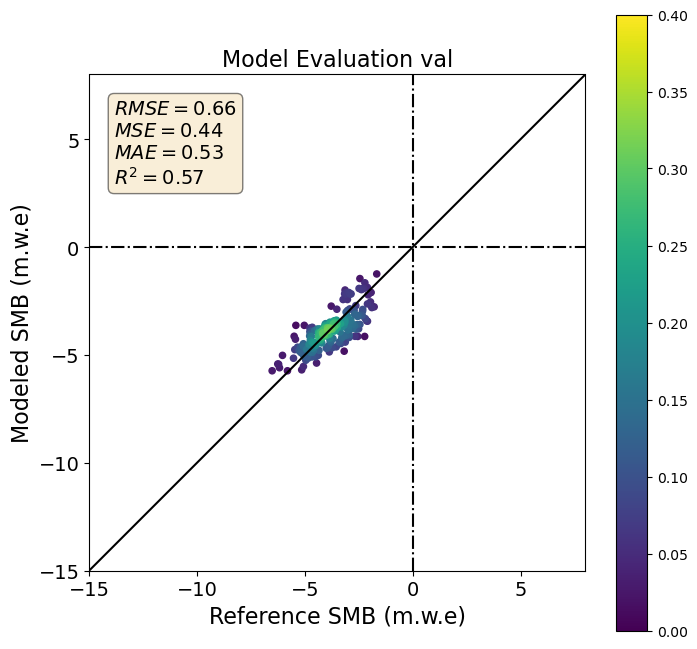

In [172]:
X_val_crop = X_train[4000:5000,:]
y_val_crop = y_train[4000:5000]

pred_val = xgb_model.predict(X_val_crop)

preds_sum = pred_val.reshape(-1, 5).sum(axis=1)
y_val_mean = y_val_crop.reshape(-1,5).mean(axis=1)
plot_prediction(y_val_mean, preds_sum, data_type='val')

In [57]:
y_val_crop.shape

(1000, 1)

In [173]:
pred_val[:100]

array([-0.37402698, -0.6426172 , -1.0322737 , -0.82881653, -0.5625017 ,
       -0.3276355 , -0.06973882, -0.53931767, -0.58683354, -0.45187628,
       -0.2513728 , -0.564912  , -0.89163625, -0.5335174 , -0.30350772,
       -0.31371343, -0.07146614, -0.5253955 , -0.5729114 , -0.43795422,
       -0.23079534, -0.23811094, -0.545596  , -0.53920907, -0.44022685,
       -0.198022  , -0.5880647 , -0.5931963 , -0.51232815, -0.21381074,
       -0.2790751 , -0.19020349, -0.27679947, -0.7073942 , -0.4682747 ,
       -0.25935867, -0.5221945 , -0.5305161 , -0.565534  , -0.23159832,
       -0.2981399 , -0.09700667, -0.44374564, -0.56426513, -0.25639454,
       -0.2827556 , -0.3696346 , -0.84969157, -0.6532577 , -0.02930904,
       -0.04878978, -0.11568356, -0.45897576, -0.3402591 , -0.28552634,
       -0.23643783, -0.33627802, -0.4893047 , -0.66323966, -0.3825778 ,
       -0.28198123, -0.5859206 , -0.573542  , -0.6994896 , -0.07565103,
       -0.10095695, -0.32723457, -0.32787004, -0.5658091 , -0.14

In [38]:
X_train_crop = X_train[-12*400:,:]
y_train_crop = y_train[-12*400:]

In [53]:
y_train.shape

(67909, 1)

In [113]:
# Simple test with annual mb - WORKS WITH CustomRegressor() but not 
# with CustomXGBRegressor()

X_train_crop = X_train[-12*400:,:]
y_train_crop = y_train[-12*400:]

xgb_model = CustomRegressor()

xgb_model.fit(X_train_crop, y_train_crop)

# Make predictions on the test data
predictions = xgb_model.predict(X_train_crop)

# Print out a comparison, e.g., the first 10 predictions vs the actual values
#print("Predictions vs Actual:")
#print(predictions[:5].sum())
#print(y_train_crop[:5].mean())
#print(predictions[5:10].sum())
#print(y_train_crop[5:10].mean())
#print(predictions[10:15].sum())
#print(y_train_crop[10:15].mean())

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


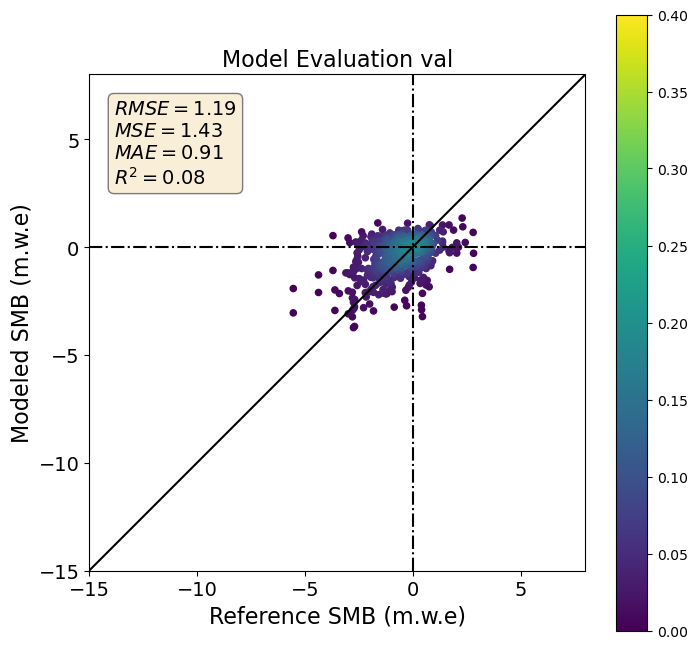

In [114]:
X_val_crop = X_train[-12*600:-12*400,:]
y_val_crop = y_train[-12*600:-12*400]

pred_val = xgb_model.predict(X_val_crop)

preds_sum = pred_val.reshape(-1, 5).sum(axis=1)
y_val_mean = y_val_crop.reshape(-1,5).mean(axis=1)
plot_prediction(y_val_mean, preds_sum, data_type='val')

In [117]:
pred_val[:12*5]

array([ 0.17804249, -0.282236  , -0.17627338, -0.47799295, -0.4330734 ,
       -0.11762414,  0.12062255,  0.20047283,  0.20145118,  0.17804249,
        0.17804249,  0.17804249,  0.13863458, -0.321644  , -0.21568131,
       -0.5184937 , -0.46468687, -0.15703206,  0.08121464,  0.1610649 ,
        0.16204324,  0.13863458,  0.13863458,  0.13863458,  0.15694942,
        0.1766414 , -0.26293004, -0.23147906, -0.21848688, -0.41097432,
        0.04470415,  0.09603289,  0.17937973,  0.20066637,  0.15694942,
        0.15694942,  0.2732628 , -0.18908341, -0.08312069, -0.3996236 ,
       -0.3536111 , -0.02447145,  0.21377525,  0.29362556,  0.29460397,
        0.2732628 ,  0.2732628 ,  0.2732628 , -0.2881939 , -0.46307287,
       -0.6160472 , -0.6347773 , -0.31181347, -0.27157283, -0.27413136,
       -0.2748437 , -0.14924994, -0.27637693, -0.2847167 , -0.30855668],
      dtype=float32)

In [130]:
# Test with fold consisting of summer, winter, annual

fold_indices = []

for train_index, test_index in group_kf.split(X_train, y_train, gp_s):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("shape(train):", train_index.shape, "test:", test_index.shape)
    fold_indices.append((train_index, test_index))

TRAIN: [    0     1     2 ... 67894 67895 67896] TEST: [   15    16    17 ... 67906 67907 67908]
shape(train): (54329,) test: (13580,)
TRAIN: [    0     1     2 ... 67906 67907 67908] TEST: [   10    11    12 ... 67858 67859 67860]
shape(train): (54329,) test: (13580,)
TRAIN: [    0     1     2 ... 67906 67907 67908] TEST: [    5     6     7 ... 67846 67847 67848]
shape(train): (54326,) test: (13583,)
TRAIN: [    0     1     2 ... 67906 67907 67908] TEST: [   25    26    27 ... 67834 67835 67836]
shape(train): (54326,) test: (13583,)
TRAIN: [    5     6     7 ... 67906 67907 67908] TEST: [    0     1     2 ... 67894 67895 67896]
shape(train): (54326,) test: (13583,)


In [131]:
X_train_crop = X_train[fold_indices[0][0],:]
X_val_crop = X_train[fold_indices[0][1],:]
y_train_crop = y_train[fold_indices[0][0]]
y_val_crop = y_train[fold_indices[0][1]]

In [132]:
print(X_train_crop.shape)
print(X_val_crop.shape)
print(y_train_crop.shape)
print(y_val_crop.shape)

(54329, 14)
(13580, 14)
(54329, 1)
(13580, 1)


In [68]:
xgb_model_split = CustomRegressor()

xgb_model_split.fit(X_train_crop, y_train_crop)

# Make predictions on the test data
predictions = xgb_model_split.predict(X_val_crop)

In [133]:
predictions = xgb_model_split.predict(X_val_crop)

In [134]:
print(predictions[-12*5:])
print(X_val_crop[-12*5:,-1])

[ 0.36243892  0.32215223  0.39523923  0.21254969  0.41564822  0.6096362
  0.26140964 -0.30920467 -0.35563952 -0.5381377  -0.723774   -0.629535
  0.29880214  0.2047695   0.10818803  0.09052835  0.1813663   0.2947557
  0.09034534 -0.29469085 -0.60441893 -1.0408107  -0.6680021  -0.19640976
  0.4166408   0.37926373  0.41837415  0.43603384  0.43437183  0.23017597
  0.35880554 -0.3151525  -0.18547136 -0.42478713 -0.6284161  -0.16715142
  0.3773723   0.3797915   0.42515472  0.4428144   0.4411524   0.23695652
  0.3593333  -0.30837193 -0.18494359 -0.4242594  -0.58916557 -0.16662365
  0.38134852  0.47175214  0.544839    0.36214972  0.565248    0.7733479
  0.42512137 -0.18443571 -0.22184816 -0.26902375 -0.4558683  -0.40888926]
['oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'may' 'jun' 'jul' 'aug' 'sep'
 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'may' 'jun' 'jul' 'aug' 'sep'
 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'may' 'jun' 'jul' 'aug' 'sep'
 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'may' 'jun' 

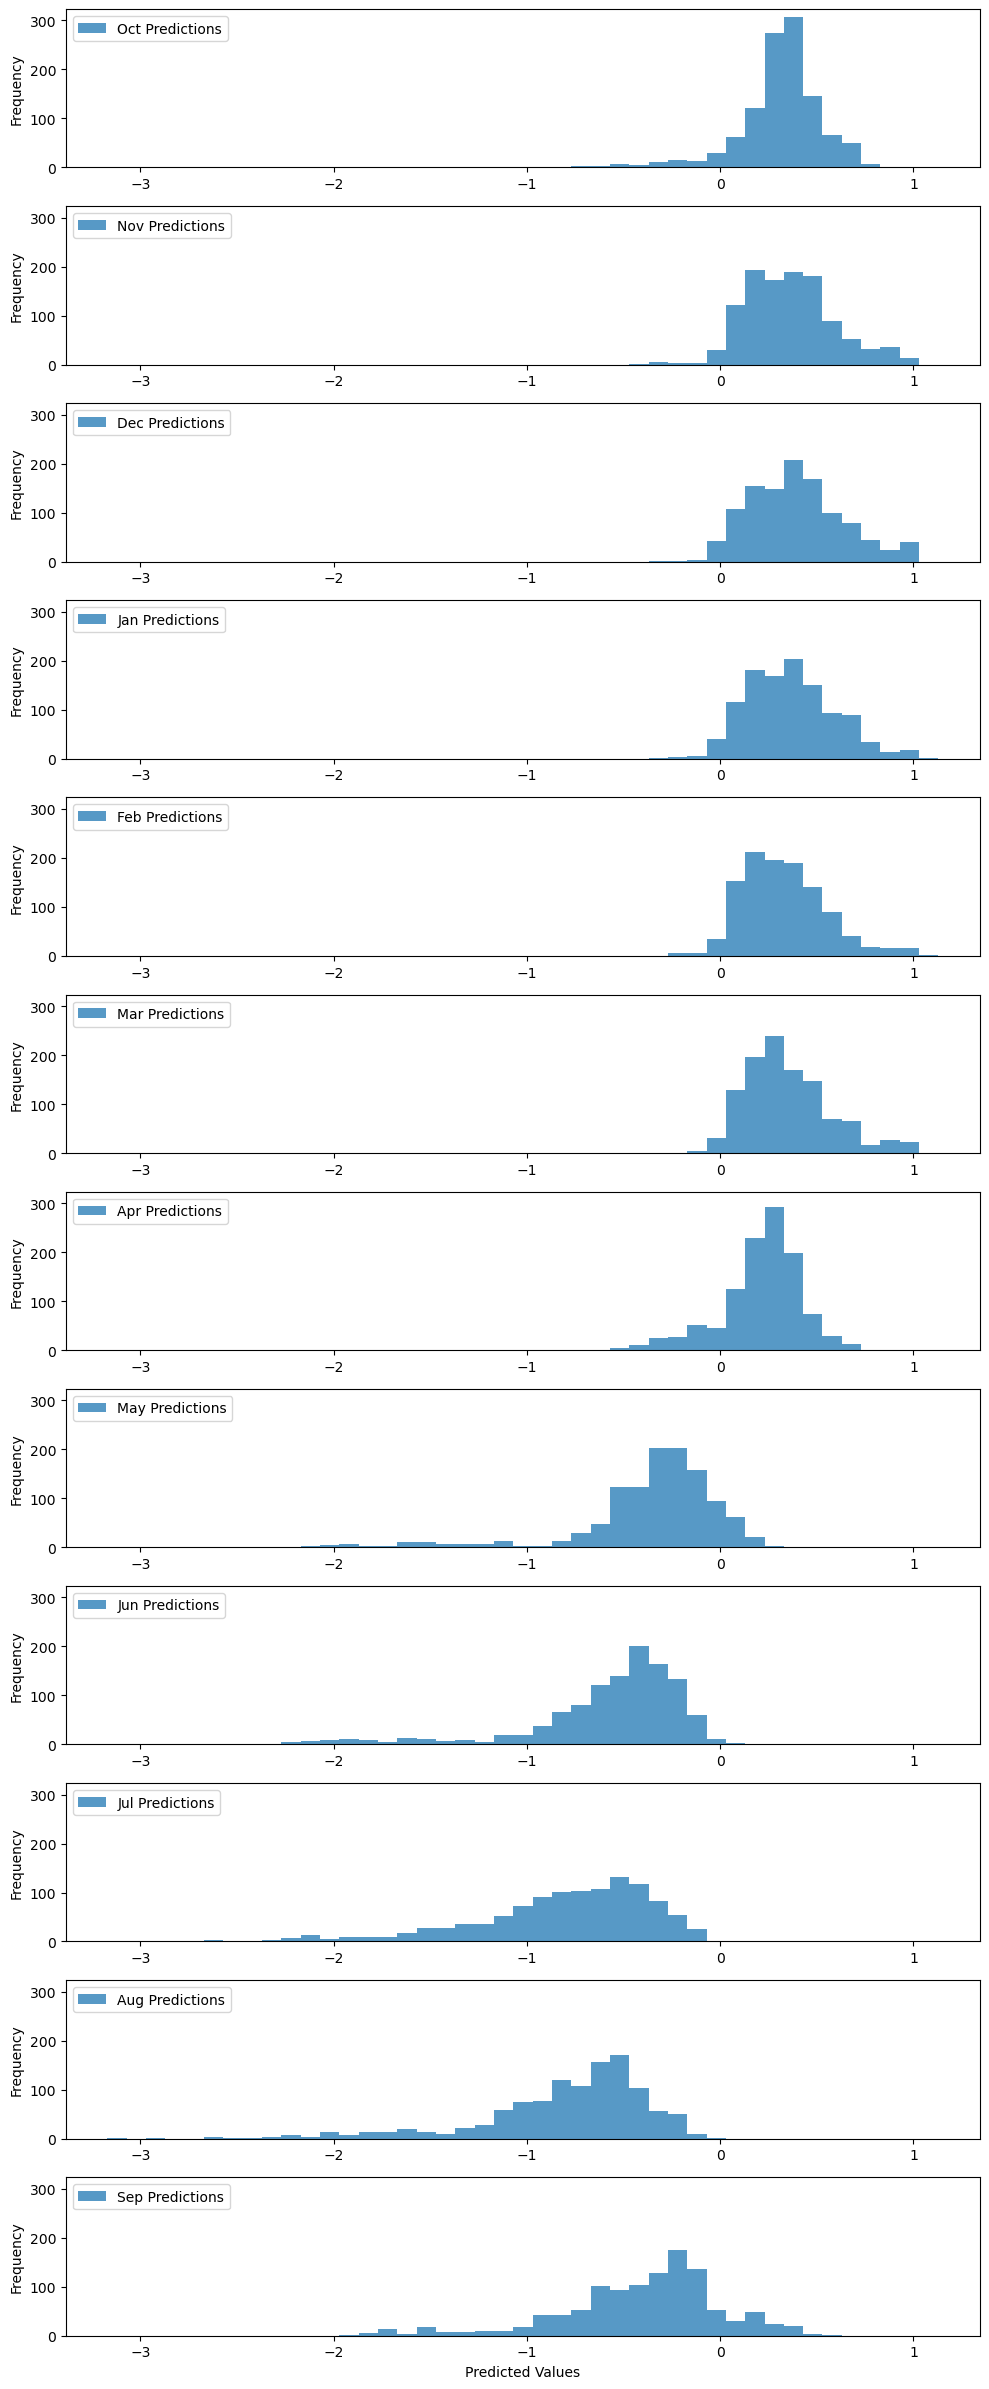

In [138]:
# Plot predicted mass balance distribution for each month

import matplotlib.pyplot as plt

months = X_val_crop[:,-1]

# Define the month order
month_order = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep']

bin_width = 0.1  # Set your desired bin width

# Determine the global min and max predictions to set consistent bins for all histograms
min_pred = predictions.min()
max_pred = predictions.max()

# Create bins with the specified width from the global min to max prediction
bins = np.arange(min_pred, max_pred + bin_width, bin_width)

fig, ax = plt.subplots(len(month_order), 1, figsize=(10, 2*len(month_order)), sharex = True, sharey=True)

for i, month in enumerate(month_order):
    # Select predictions for each month
    month_predictions = predictions[months == month]
    
    # Plot the histogram for this month
    ax[i].hist(month_predictions, bins=bins, alpha=0.75, label=f'{month.capitalize()} Predictions')

    # Set the x-ticks for each subplot so they're visible
    ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
    
    #ax[i].set_title(f'{month.capitalize()} distribution')
    ax[i].set_ylabel('Frequency')
    ax[i].legend(loc='upper left')

# Set common x-axis label
ax[-1].set_xlabel('Predicted Values')

plt.tight_layout()

plt.show()

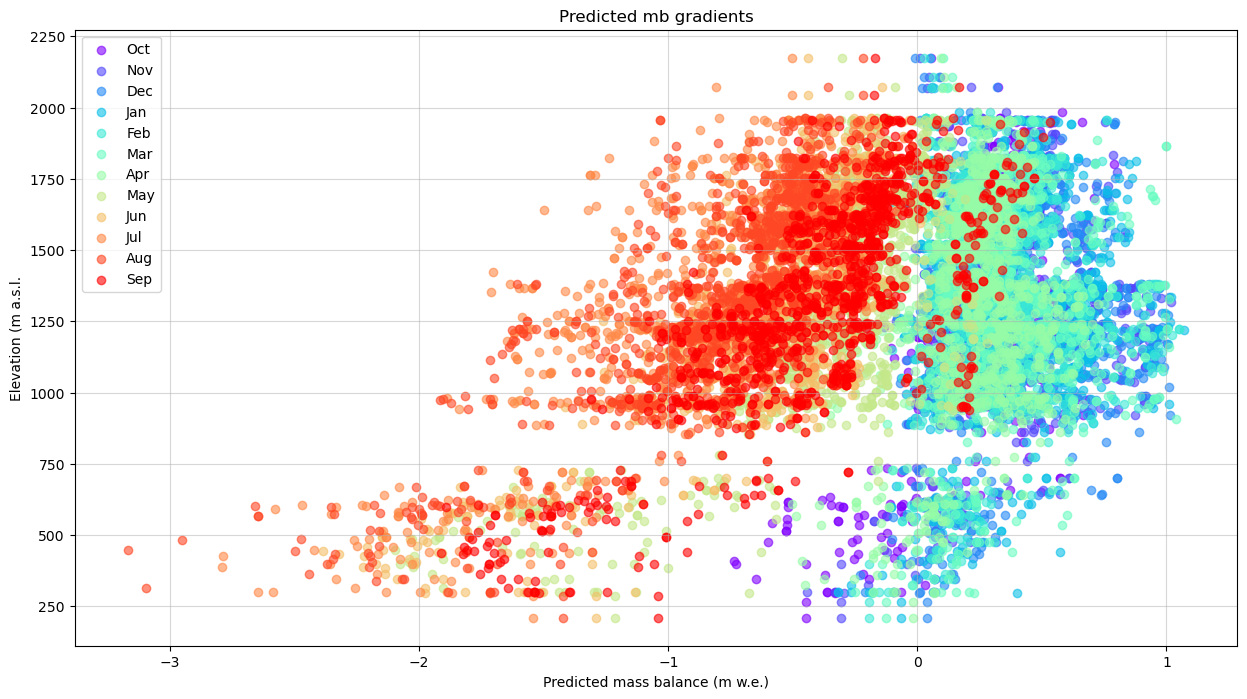

In [144]:
# Plot predicted mass balance gradient for each month

import matplotlib.pyplot as plt

months = X_val_crop[:,-1]
elevation = X_val_crop[:,0]

# Define month order
month_order = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep']
colors = plt.cm.rainbow(np.linspace(0, 1, len(month_order)))

# Map month to color
month_to_color = dict(zip(month_order, colors))

fig, ax = plt.subplots(figsize=(15, 8))

for month in month_order:
    idx = months == month
    ax.scatter(predictions[idx], elevation[idx], label=month.capitalize(), alpha=0.6, c=[month_to_color[month]])

ax.set_xlabel('Predicted mass balance (m w.e.)')
ax.set_ylabel('Elevation (m a.s.l.')
ax.set_title('Predicted mb gradients')
ax.legend()

plt.grid(alpha=0.5)
plt.show()

In [90]:
def get_ytrue_y_pred_agg(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [91]:
y_true_mean, y_pred_agg = get_ytrue_y_pred_agg(y_train_crop,predictions,X_train_crop)

In [99]:
y_true_mean, y_pred_agg = get_ytrue_y_pred_agg(y_val_crop,predictions,X_val_crop)

In [87]:
metadata=X_train_crop[:,-3:]
unique_ids = np.unique(metadata[:,0])
indexes = metadata[:,0]==0
np.mean(y_train_crop[indexes])

-3.41

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


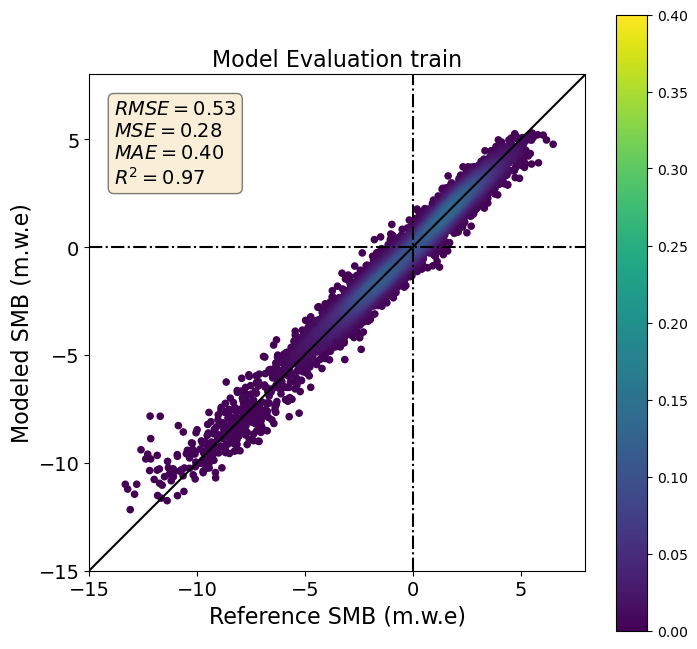

In [97]:
plot_prediction(y_true_mean, y_pred_agg, data_type='train')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


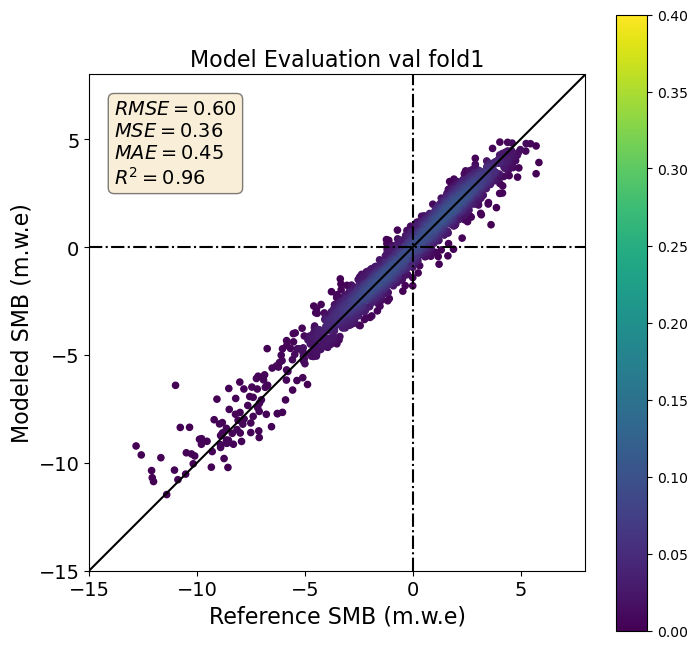

In [100]:
plot_prediction(y_true_mean, y_pred_agg, data_type='val fold1')

In [106]:
test_pred = xgb_model_split.predict(X_test)

In [107]:
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


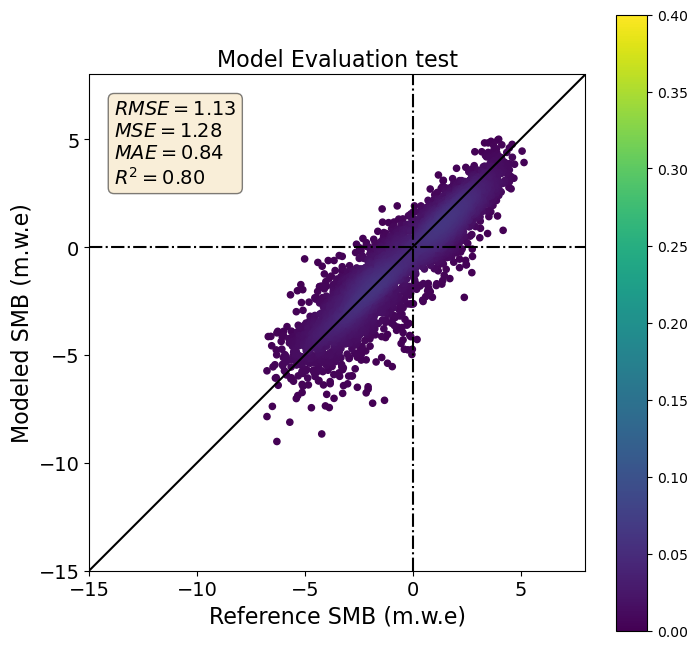

In [108]:
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

#### Run tests for custom estimators: CustomXGBRegressor()

In [215]:
# Simple test with summer months

X_train_crop = X_train[:4000,:]
y_train_crop = y_train[:4000]

xgbreg_model = CustomXGBRegressor(n_estimators=100, learning_rate=0.1)

xgbreg_model.fit(X_train_crop, y_train_crop)

# Make predictions on the test data
predictions_xgbreg = xgbreg_model.predict(X_train_crop)

# Print out a comparison, e.g., the first 10 predictions vs the actual values
print("Predictions vs Actual:")
print(predictions_xgbreg[:5].sum())
print(y_train_crop[:5].mean())
print(predictions_xgbreg[5:10].sum())
print(y_train_crop[5:10].mean())
print(predictions_xgbreg[10:15].sum())
print(y_train_crop[10:15].mean())

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:47:33] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


Predictions vs Actual:
-3.3930202
-3.41
-2.1958752
-2.16
-2.9364743
-2.9


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


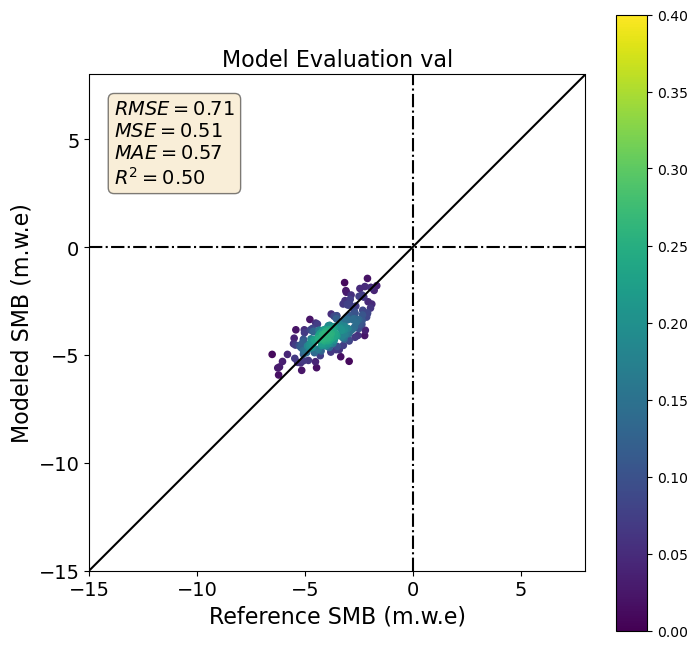

In [216]:
X_val_crop = X_train[4000:5000,:]
y_val_crop = y_train[4000:5000]

pred_val = xgbreg_model.predict(X_val_crop)

preds_sum = pred_val.reshape(-1, 5).sum(axis=1)
y_val_mean = y_val_crop.reshape(-1,5).mean(axis=1)
plot_prediction(y_val_mean, preds_sum, data_type='val')

In [170]:
pred_val[:100]

array([-0.53654194, -0.47694325, -0.76559734, -0.62808156, -0.3296873 ,
       -0.08772216,  0.04531639, -0.36707225, -0.40258712, -0.23696525,
       -0.29754972, -0.54417926, -0.70626765, -0.6181232 , -0.22311765,
       -0.22237277, -0.06528582, -0.5058125 , -0.5400983 , -0.3974781 ,
       -0.57049245, -0.58153445, -0.7372264 , -0.7826727 , -0.422023  ,
       -0.44851646, -0.6084407 , -0.6491343 , -0.65594465, -0.3449248 ,
       -0.33417815, -0.30836263, -0.43636897, -0.49288428, -0.4014706 ,
       -0.50555336, -0.5013257 , -0.6095269 , -0.5672582 , -0.39287466,
       -0.39569554, -0.09385018, -0.3742553 , -0.46205097, -0.19586112,
       -0.497599  , -0.21322197, -0.910722  , -0.5673883 , -0.19491845,
       -0.14354026, -0.1355022 , -0.4156033 , -0.2723614 , -0.403083  ,
       -0.27518585, -0.55078155, -0.581698  , -0.5347673 , -0.22605959,
       -0.38380024, -0.5857624 , -0.5086574 , -0.5569782 , -0.24211699,
       -0.08520225, -0.52245086, -0.3622853 , -0.4331363 , -0.16

In [223]:
# Simple test with annual mb - WORKS WITH CustomRegressor() but not 
# with CustomXGBRegressor()

X_train_crop = X_train[-12*400:,:]
y_train_crop = y_train[-12*400:]

xgb_model = CustomXGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, gamma=0)

xgb_model.fit(X_train_crop, y_train_crop)

# Make predictions on the test data
predictions = xgb_model.predict(X_train_crop)

# Print out a comparison, e.g., the first 10 predictions vs the actual values
#print("Predictions vs Actual:")
#print(predictions[:5].sum())
#print(y_train_crop[:5].mean())
#print(predictions[5:10].sum())
#print(y_train_crop[5:10].mean())
#print(predictions[10:15].sum())
#print(y_train_crop[10:15].mean())
#features = X_train_crop[:,:-3]

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:50:33] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


In [224]:
predictions[:100]

array([-0.3170913 , -0.29672852, -0.30063316, -0.39244202, -0.6660081 ,
       -0.6337917 , -0.33183566, -0.32571125, -0.70628566, -1.1368939 ,
       -0.32671228, -0.32671228, -0.3134572 , -0.19853216, -0.38323194,
       -0.31470242, -0.47760206, -0.28486758, -0.33183566, -0.31848544,
       -0.27584505, -0.5893063 , -0.32464474, -0.32464474, -0.32221466,
       -0.28118286, -0.62759334, -0.64667517, -0.62759334, -0.33370605,
       -0.29812267, -0.33183566, -0.32571125, -0.5359999 , -0.31848544,
       -0.31848544, -0.32671228, -0.62759334, -0.6744827 , -0.28883368,
       -0.6530884 , -0.2910269 , -0.3266606 , -0.32464474, -0.3170913 ,
       -0.48744175, -0.32464474, -0.32671228, -0.31502375, -0.3134572 ,
       -0.1911747 , -0.30537713, -0.24488083, -0.31502375, -0.3114729 ,
       -0.27584505, -0.32221466, -0.3170913 , -0.31848544, -0.32464474,
       -0.30886444, -0.29672852, -0.5451032 , -0.55890554, -0.62759334,
       -0.62759334, -0.32464474, -0.31502375, -0.31502375, -0.88

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


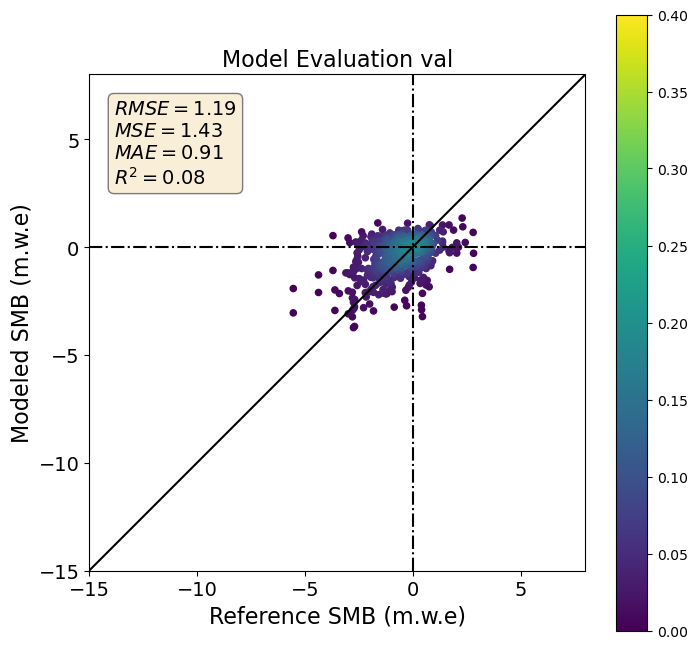

In [225]:
X_val_crop = X_train[-12*600:-12*400,:]
y_val_crop = y_train[-12*600:-12*400]

pred_val = xgb_model.predict(X_val_crop)

preds_sum = pred_val.reshape(-1, 5).sum(axis=1)
y_val_mean = y_val_crop.reshape(-1,5).mean(axis=1)
plot_prediction(y_val_mean, preds_sum, data_type='val')

In [226]:
# Test with fold consisting of summer, winter, annual

fold_indices = []

for train_index, test_index in group_kf.split(X_train, y_train, gp_s):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("shape(train):", train_index.shape, "test:", test_index.shape)
    fold_indices.append((train_index, test_index))

TRAIN: [    0     1     2 ... 67894 67895 67896] TEST: [   15    16    17 ... 67906 67907 67908]
shape(train): (54329,) test: (13580,)
TRAIN: [    0     1     2 ... 67906 67907 67908] TEST: [   10    11    12 ... 67858 67859 67860]
shape(train): (54329,) test: (13580,)
TRAIN: [    0     1     2 ... 67906 67907 67908] TEST: [    5     6     7 ... 67846 67847 67848]
shape(train): (54326,) test: (13583,)
TRAIN: [    0     1     2 ... 67906 67907 67908] TEST: [   25    26    27 ... 67834 67835 67836]
shape(train): (54326,) test: (13583,)
TRAIN: [    5     6     7 ... 67906 67907 67908] TEST: [    0     1     2 ... 67894 67895 67896]
shape(train): (54326,) test: (13583,)


In [227]:
X_train_crop = X_train[fold_indices[0][0],:]
X_val_crop = X_train[fold_indices[0][1],:]
y_train_crop = y_train[fold_indices[0][0]]
y_val_crop = y_train[fold_indices[0][1]]

In [228]:
print(X_train_crop.shape)
print(X_val_crop.shape)
print(y_train_crop.shape)
print(y_val_crop.shape)

(54329, 14)
(13580, 14)
(54329, 1)
(13580, 1)


In [229]:
xgb_model_split = CustomXGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, gamma=0)

xgb_model_split.fit(X_train_crop, y_train_crop)

# Make predictions on the test data
predictions = xgb_model_split.predict(X_val_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:52:57] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


In [230]:
predictions = xgb_model_split.predict(X_val_crop)

In [231]:
print(predictions[-12*5:])
print(X_val_crop[-12*5:,-1])

[ 0.36243892  0.32215223  0.39523923  0.21254969  0.41564822  0.6096362
  0.26140964 -0.30920467 -0.35563952 -0.5381377  -0.723774   -0.629535
  0.29880214  0.2047695   0.10818803  0.09052835  0.1813663   0.2947557
  0.09034534 -0.29469085 -0.60441893 -1.0408107  -0.6680021  -0.19640976
  0.4166408   0.37926373  0.41837415  0.43603384  0.43437183  0.23017597
  0.35880554 -0.3151525  -0.18547136 -0.42478713 -0.6284161  -0.16715142
  0.3773723   0.3797915   0.42515472  0.4428144   0.4411524   0.23695652
  0.3593333  -0.30837193 -0.18494359 -0.4242594  -0.58916557 -0.16662365
  0.38134852  0.47175214  0.544839    0.36214972  0.565248    0.7733479
  0.42512137 -0.18443571 -0.22184816 -0.26902375 -0.4558683  -0.40888926]
['oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'may' 'jun' 'jul' 'aug' 'sep'
 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'may' 'jun' 'jul' 'aug' 'sep'
 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'may' 'jun' 'jul' 'aug' 'sep'
 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'may' 'jun' 

In [233]:
y_true_mean, y_pred_agg = get_ytrue_y_pred_agg(y_val_crop,predictions,X_val_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


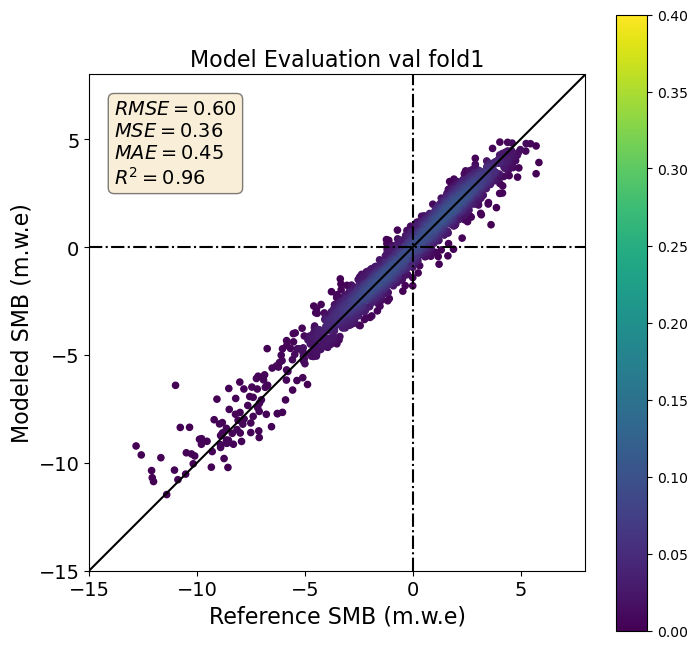

In [236]:
plot_prediction(y_true_mean, y_pred_agg, data_type='val fold1')

In [237]:
test_pred = xgb_model_split.predict(X_test)

In [238]:
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


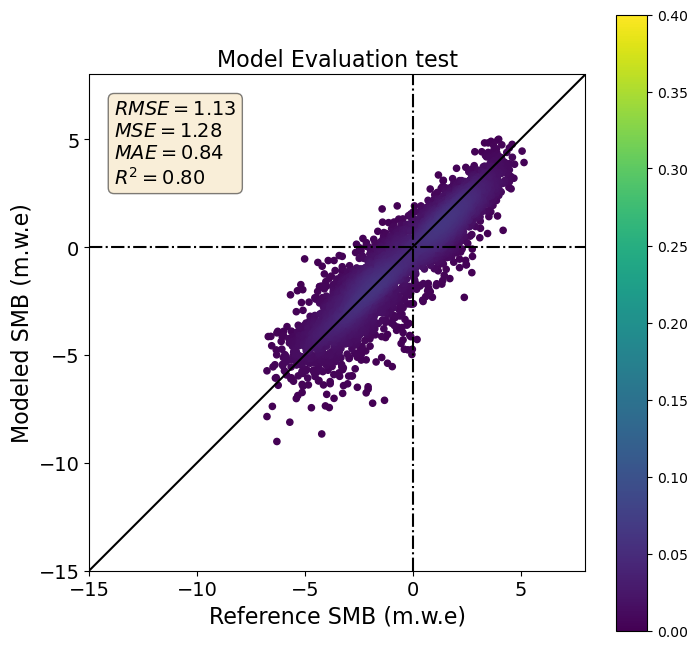

In [239]:
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

## Grid search with custom XGBRegressor model and objective/loss function

#### Make custom scorer to use in grid search

In [52]:
# Need to use the make_scorer function to turn the 
# custom evaluation function into a scorer object
from sklearn.metrics import make_scorer

def custom_mse_scorer(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata

    # Initialize the squared error
    mse = 0.0
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID, e.g. sum or mean of the predictions
        y_pred_agg = np.mean(y_pred[indexes]) # Here mean is used.
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        # Compute squared error for the ID group
        mse += (y_pred_agg - y_true_mean) ** 2
    
    # Calculate the mean squared error
    mse /= len(unique_ids)
    return -mse  # Return negative because GridSearchCV maximizes the score

# Wrap custom mse scorer to pass metadata within the X dataset
def make_custom_mse_scorer():
    """Generates a customized scorer callable as required by GridSearchCV"""
    return make_scorer(custom_mse_scorer, greater_is_better=False, needs_proba=False)

# Use the custom scorer for grid search
custom_scorer = make_custom_mse_scorer()


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [54]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4],#, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1],#, 0.2, 0.3],
    'n_estimators': [500],
    'gamma':[0]#, 1, 10],
    }

# Define instance of custom XGBRegressor
xgb_model = CustomXGBRegressor()

# Set up grid search. 
clf = GridSearchCV(xgb_model, 
                   param_grid, 
                   cv=splits_s, # Int or iterator (default for int is kfold)
                   verbose=2, # Controls number of messages
                   n_jobs=4, # No of parallell jobs
                   scoring=custom_scorer, # Can use multiple metrics
                   refit=True, # Default True. For multiple metric evaluation, refit must be str denoting scorer to be used 
                               #to find the best parameters for refitting the estimator.
                   error_score='raise',
                   return_train_score=True) # Default False. If False, cv_results_ will not include training scores.

#X_features = X_train[:,:-3]
# Fit model to folds
clf.fit(X_train, y_train)

# After fitting, you can find the best parameters and the best score:
#best_params = grid_search.best_params_
#best_score = grid_search.best_score_

#print(f"Best parameters: {best_params}")
#print(f"Best score: {best_score}")



Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: 